In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import  DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import scipy.io
import os

/Users/mclinwong/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Seed is important, especially training the CNN+ReLU Net
#Otherwise, the results will be very different
myseed = 8974  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [3]:
#Train&Test Data library
matlib = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/matlib'
#Path to save figures
figure_savepath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/ReproducedCodes/Figures/'
#Path to save the model
pthpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/pth/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
num_epoch = 300
batch_size = 64
learning_rate = 0.001
# load model
# autoencoder = torch.load('/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/ReproducedCodes/matlib/11_22/autoencoder.h5')

In [4]:
datapath = os.path.join(matlib, 'data2_trainlow.mat')
read_data = scipy.io.loadmat(datapath)
S_est = read_data['S_est']
S_abs = read_data['S_abs']
S_label = read_data['S_label']
R_est = read_data['R_est']
S_label1 = np.expand_dims(S_label, 2)
[Sample, L, dim] = np.shape(S_est)
S_est = S_est.transpose(0, 2, 1)
S_label1 = S_label1.transpose(0, 2, 1)

print(f'S_est.shape: {S_est.shape}')
print(f'S_abs.shape: {S_abs.shape}')
print(f'S_label.shape: {S_label.shape}')
print(f'S_label1.shape: {S_label1.shape}')
print(f'Sample: {Sample}, L: {L}, dim: {dim}')

S_est.shape: (19800, 2, 120)
S_abs.shape: (19800, 240)
S_label.shape: (19800, 120)
S_label1.shape: (19800, 1, 120)
Sample: 19800, L: 120, dim: 2


In [5]:
class MakeDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        label = self.label[idx]
        data = self.data[idx]
        return data, label

In [6]:
S_est_train, S_est_test, S_label1_train, S_label1_test = train_test_split(S_est, S_label1, test_size=0.2)
S_abs_train, S_abs_test, S_label_train, S_label_test = train_test_split(S_abs, S_label, test_size=0.2)
print(f'S_est_train.shape: {S_est_train.shape}, S_est_test.shape: {S_est_test.shape}')
print(f'S_abs_train.shape: {S_abs_train.shape}, S_abs_test.shape: {S_abs_test.shape}')
print(f'S_label1_train.shape: {S_label1_train.shape}, S_label1_test.shape: {S_label1_test.shape}')

train_set = MakeDataset(S_est_train, S_label1_train)
train_set_fcn = MakeDataset(S_abs_train, S_label_train)
valid_set = MakeDataset(S_est_test, S_label1_test)
valid_set_fcn = MakeDataset(S_abs_test, S_label_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
train_loader_fcn = DataLoader(train_set_fcn, batch_size=batch_size, shuffle=True)
valid_loader_fcn = DataLoader(valid_set_fcn, batch_size=batch_size, shuffle=False)

S_est_train.shape: (15840, 2, 120), S_est_test.shape: (3960, 2, 120)
S_abs_train.shape: (15840, 240), S_abs_test.shape: (3960, 240)
S_label1_train.shape: (15840, 1, 120), S_label1_test.shape: (3960, 1, 120)


# Define Nets

In [7]:
# Shape of Conv1D: (batch_size, channels, seq_len)
# length_out = (length_in - kernel_size + 2 * padding) / stride + 1
class CNN(nn.Module):
    def __init__(self,activ):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(2,12,kernel_size=25, padding=12), nn.BatchNorm1d(12), activ())
        self.conv2 = nn.Sequential(nn.Conv1d(12,6,kernel_size=15, padding=7),  nn.BatchNorm1d(6), activ())
        self.conv3 = nn.Sequential(nn.Conv1d(6,3,kernel_size=5, padding=2), nn.BatchNorm1d(3), activ())
        self.conv4 = nn.Sequential(nn.Conv1d(3,1,kernel_size=3, padding=1),nn.BatchNorm1d(1), activ())
    
    def forward(self, x):  
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
       
        return out

In [8]:
#L=120, 
#in_num = 2*L = 240
#out1_num = int(2*L/3) = 80
#out2_num = int(4*L/9) = 53
#out3_num = int(2*L/3) = 80
#out4_num = L = 120
class DNN(nn.Module):
    def __init__(self, activa):
        super(DNN, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(2*L, int(2*L/3)), nn.BatchNorm1d(80), activa())
        self.fc2 = nn.Sequential(nn.Linear(int(2*L/3), int(4*L/9)), nn.BatchNorm1d(53), activa())
        self.fc3 = nn.Sequential(nn.Linear(int(4*L/9), int(2*L/3)), nn.BatchNorm1d(80), activa())
        self.fc4 = nn.Sequential(nn.Linear(int(2*L/3), L), nn.BatchNorm1d(120), activa())
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

# TRAIN Function

In [9]:
def train(model, train_loader, valid_loader, epoch, name):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    train_loss_list = []
    valid_loss_list = []
    
    for epoch in range(num_epoch):
        model.train()
        train_loss = []
        
        for x, y in tqdm(train_loader):
            optimizer.zero_grad()
            x = x.to('cpu').float()
            x = x.to(device)
            y = y.to('cpu').float()
            y = y.to(device)
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        train_loss_list.append(train_loss)
        print('Epoch: {}, Train Loss: {:.4f}'.format(epoch, train_loss))
    
        model.eval()
        valid_loss = []
        
        for x, y in tqdm(valid_loader):
            x = x.to('cpu').float()
            x = x.to(device)
            y = y.to('cpu').float()
            y = y.to(device)
            with torch.no_grad():
                output = model(x)
            loss = criterion(output, y)
            valid_loss.append(loss.item())
            
        valid_loss = np.mean(valid_loss)
        valid_loss_list.append(valid_loss)
        print('Epoch: {}, Valid Loss: {:.4f}'.format(epoch, valid_loss))
    
    #save loss as csv
    id = np.arange(0, num_epoch)
    datafarme = pd.DataFrame({'id':id ,'train_loss':train_loss_list, 'valid_loss':valid_loss_list})
    datafarme.to_csv(figure_savepath + str(name) +'loss.csv', index=False, sep=',')
    return train_loss_list, valid_loss_list

# Train & Save models

In [10]:


CNN_ReLU = CNN(nn.ReLU).to(device)
CNN_Tanh = CNN(nn.Tanh).to(device)
CNN_Sigmoid = CNN(nn.Sigmoid).to(device)

DNN_ReLU = DNN(nn.ReLU).to(device)
DNN_Tanh = DNN(nn.Tanh).to(device)
DNN_Sigmoid = DNN(nn.Sigmoid).to(device)

tll_cnn_relu, vll_cnn_relu = train(
    CNN_ReLU, train_loader, valid_loader, num_epoch, 'CNN_ReLU')
torch.save(CNN_ReLU, pthpath + 'cnnrelu.pth')

tll_cnn_tanh, vll_cnn_tanh = train(
    CNN_Tanh, train_loader, valid_loader, num_epoch, 'CNN_Tanh')
torch.save(CNN_Tanh, pthpath + 'cnntanh.pth')

tll_cnn_sigmoid, vll_cnn_sigmoid = train(
    CNN_Sigmoid, train_loader, valid_loader, num_epoch, 'CNN_Sigmoid')
torch.save(CNN_Sigmoid, pthpath + 'cnnsigmoid.pth')
 
tll_dnn_relu, vll_dnn_relu = train(
    DNN_ReLU, train_loader_fcn, valid_loader_fcn, num_epoch, 'DNN_ReLU')
torch.save(DNN_ReLU, pthpath + 'dnnrelu.pth')

tll_dnn_tanh, vll_dnn_tanh = train(
    DNN_Tanh, train_loader_fcn, valid_loader_fcn, num_epoch, 'DNN_Tanh')
torch.save(DNN_Tanh, pthpath + 'dnntanh.pth')

tll_dnn_sigmoid, vll_dnn_sigmoid = train(
    DNN_Sigmoid, train_loader_fcn, valid_loader_fcn, num_epoch, 'DNN_Sigmoid')
torch.save(DNN_Sigmoid, pthpath + 'dnnsigmoid.pth')

100%|██████████| 248/248 [00:02<00:00, 91.03it/s]


Epoch: 273, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 407.90it/s]


Epoch: 273, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.45it/s]


Epoch: 274, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 415.31it/s]


Epoch: 274, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.74it/s]


Epoch: 275, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 414.54it/s]


Epoch: 275, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.71it/s]


Epoch: 276, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 414.51it/s]


Epoch: 276, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.12it/s]


Epoch: 277, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 406.18it/s]


Epoch: 277, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.06it/s]


Epoch: 278, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 411.32it/s]


Epoch: 278, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.05it/s]


Epoch: 279, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 418.91it/s]


Epoch: 279, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.77it/s]


Epoch: 280, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 412.55it/s]


Epoch: 280, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 93.80it/s]


Epoch: 281, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 416.20it/s]


Epoch: 281, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.45it/s]


Epoch: 282, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 395.26it/s]


Epoch: 282, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.44it/s]


Epoch: 283, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 419.84it/s]


Epoch: 283, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.24it/s]


Epoch: 284, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 422.19it/s]


Epoch: 284, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 93.02it/s]


Epoch: 285, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 422.07it/s]


Epoch: 285, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.08it/s]


Epoch: 286, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 420.08it/s]


Epoch: 286, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.23it/s]


Epoch: 287, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 416.60it/s]


Epoch: 287, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.23it/s]


Epoch: 288, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 424.63it/s]


Epoch: 288, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.08it/s]


Epoch: 289, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 419.76it/s]


Epoch: 289, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.95it/s]


Epoch: 290, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 418.79it/s]


Epoch: 290, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.42it/s]


Epoch: 291, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 415.44it/s]


Epoch: 291, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.61it/s]


Epoch: 292, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 415.70it/s]


Epoch: 292, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 93.11it/s]


Epoch: 293, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 422.20it/s]


Epoch: 293, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 95.31it/s]


Epoch: 294, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 427.86it/s]


Epoch: 294, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.46it/s]


Epoch: 295, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 423.34it/s]


Epoch: 295, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.65it/s]


Epoch: 296, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 416.29it/s]


Epoch: 296, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.06it/s]


Epoch: 297, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 420.72it/s]


Epoch: 297, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 95.27it/s]


Epoch: 298, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 417.54it/s]


Epoch: 298, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.61it/s]


Epoch: 299, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 421.00it/s]


Epoch: 299, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 92.36it/s]


Epoch: 0, Train Loss: 0.0868


100%|██████████| 62/62 [00:00<00:00, 393.59it/s]


Epoch: 0, Valid Loss: 0.0427


100%|██████████| 248/248 [00:02<00:00, 94.53it/s]


Epoch: 1, Train Loss: 0.0394


100%|██████████| 62/62 [00:00<00:00, 420.82it/s]


Epoch: 1, Valid Loss: 0.0381


100%|██████████| 248/248 [00:02<00:00, 92.49it/s]


Epoch: 2, Train Loss: 0.0375


100%|██████████| 62/62 [00:00<00:00, 416.52it/s]


Epoch: 2, Valid Loss: 0.0374


100%|██████████| 248/248 [00:02<00:00, 92.19it/s]


Epoch: 3, Train Loss: 0.0361


100%|██████████| 62/62 [00:00<00:00, 415.56it/s]


Epoch: 3, Valid Loss: 0.0369


100%|██████████| 248/248 [00:02<00:00, 95.27it/s]


Epoch: 4, Train Loss: 0.0295


100%|██████████| 62/62 [00:00<00:00, 413.02it/s]


Epoch: 4, Valid Loss: 0.0286


100%|██████████| 248/248 [00:02<00:00, 93.98it/s]


Epoch: 5, Train Loss: 0.0281


100%|██████████| 62/62 [00:00<00:00, 415.82it/s]


Epoch: 5, Valid Loss: 0.0281


100%|██████████| 248/248 [00:02<00:00, 91.56it/s]


Epoch: 6, Train Loss: 0.0273


100%|██████████| 62/62 [00:00<00:00, 404.89it/s]


Epoch: 6, Valid Loss: 0.0272


100%|██████████| 248/248 [00:02<00:00, 92.55it/s]


Epoch: 7, Train Loss: 0.0268


100%|██████████| 62/62 [00:00<00:00, 413.61it/s]


Epoch: 7, Valid Loss: 0.0273


100%|██████████| 248/248 [00:02<00:00, 94.97it/s]


Epoch: 8, Train Loss: 0.0247


100%|██████████| 62/62 [00:00<00:00, 410.00it/s]


Epoch: 8, Valid Loss: 0.0210


100%|██████████| 248/248 [00:02<00:00, 95.16it/s]


Epoch: 9, Train Loss: 0.0200


100%|██████████| 62/62 [00:00<00:00, 410.90it/s]


Epoch: 9, Valid Loss: 0.0196


100%|██████████| 248/248 [00:02<00:00, 93.85it/s]


Epoch: 10, Train Loss: 0.0194


100%|██████████| 62/62 [00:00<00:00, 424.54it/s]


Epoch: 10, Valid Loss: 0.0203


100%|██████████| 248/248 [00:02<00:00, 95.04it/s]


Epoch: 11, Train Loss: 0.0191


100%|██████████| 62/62 [00:00<00:00, 420.76it/s]


Epoch: 11, Valid Loss: 0.0197


100%|██████████| 248/248 [00:02<00:00, 95.07it/s]


Epoch: 12, Train Loss: 0.0188


100%|██████████| 62/62 [00:00<00:00, 423.88it/s]


Epoch: 12, Valid Loss: 0.0187


100%|██████████| 248/248 [00:02<00:00, 94.92it/s]


Epoch: 13, Train Loss: 0.0185


100%|██████████| 62/62 [00:00<00:00, 409.88it/s]


Epoch: 13, Valid Loss: 0.0186


100%|██████████| 248/248 [00:02<00:00, 93.74it/s]


Epoch: 14, Train Loss: 0.0182


100%|██████████| 62/62 [00:00<00:00, 414.05it/s]


Epoch: 14, Valid Loss: 0.0185


100%|██████████| 248/248 [00:02<00:00, 95.04it/s]


Epoch: 15, Train Loss: 0.0178


100%|██████████| 62/62 [00:00<00:00, 412.21it/s]


Epoch: 15, Valid Loss: 0.0164


100%|██████████| 248/248 [00:02<00:00, 94.93it/s]


Epoch: 16, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 415.42it/s]


Epoch: 16, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 95.15it/s]


Epoch: 17, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 413.15it/s]


Epoch: 17, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 93.78it/s]


Epoch: 18, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 418.64it/s]


Epoch: 18, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 94.53it/s]


Epoch: 19, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 419.75it/s]


Epoch: 19, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 94.86it/s]


Epoch: 20, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 410.43it/s]


Epoch: 20, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 94.70it/s]


Epoch: 21, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 420.56it/s]


Epoch: 21, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 93.04it/s]


Epoch: 22, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 414.38it/s]


Epoch: 22, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 94.93it/s]


Epoch: 23, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 410.82it/s]


Epoch: 23, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 94.88it/s]


Epoch: 24, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 412.40it/s]


Epoch: 24, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 94.86it/s]


Epoch: 25, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 410.64it/s]


Epoch: 25, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 92.55it/s]


Epoch: 26, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 413.69it/s]


Epoch: 26, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 94.51it/s]


Epoch: 27, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 416.42it/s]


Epoch: 27, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 94.82it/s]


Epoch: 28, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 421.14it/s]


Epoch: 28, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 93.63it/s]


Epoch: 29, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 412.82it/s]


Epoch: 29, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 93.43it/s]


Epoch: 30, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 415.34it/s]


Epoch: 30, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 93.93it/s]


Epoch: 31, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 418.18it/s]


Epoch: 31, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 93.77it/s]


Epoch: 32, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 413.93it/s]


Epoch: 32, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 93.44it/s]


Epoch: 33, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 404.29it/s]


Epoch: 33, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 93.52it/s]


Epoch: 34, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 418.35it/s]


Epoch: 34, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 94.47it/s]


Epoch: 35, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 413.65it/s]


Epoch: 35, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 94.65it/s]


Epoch: 36, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 408.42it/s]


Epoch: 36, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 94.65it/s]


Epoch: 37, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 418.52it/s]


Epoch: 37, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 93.05it/s]


Epoch: 38, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 414.98it/s]


Epoch: 38, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 94.59it/s]


Epoch: 39, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 415.91it/s]


Epoch: 39, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 94.67it/s]


Epoch: 40, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 408.53it/s]


Epoch: 40, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 95.01it/s]


Epoch: 41, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 407.61it/s]


Epoch: 41, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 93.85it/s]


Epoch: 42, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 412.23it/s]


Epoch: 42, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 94.56it/s]


Epoch: 43, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 410.79it/s]


Epoch: 43, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 94.70it/s]


Epoch: 44, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 409.05it/s]


Epoch: 44, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 94.74it/s]


Epoch: 45, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 393.84it/s]


Epoch: 45, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 91.81it/s]


Epoch: 46, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 414.96it/s]


Epoch: 46, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 94.17it/s]


Epoch: 47, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 413.23it/s]


Epoch: 47, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 93.84it/s]


Epoch: 48, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 409.67it/s]


Epoch: 48, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 94.26it/s]


Epoch: 49, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 409.41it/s]


Epoch: 49, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 93.24it/s]


Epoch: 50, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 413.16it/s]


Epoch: 50, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 94.46it/s]


Epoch: 51, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 416.09it/s]


Epoch: 51, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 94.83it/s]


Epoch: 52, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 416.06it/s]


Epoch: 52, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 94.90it/s]


Epoch: 53, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 421.05it/s]


Epoch: 53, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 93.97it/s]


Epoch: 54, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 413.64it/s]


Epoch: 54, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 94.51it/s]


Epoch: 55, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 409.42it/s]


Epoch: 55, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 94.74it/s]


Epoch: 56, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 413.61it/s]


Epoch: 56, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 95.09it/s]


Epoch: 57, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 412.94it/s]


Epoch: 57, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 93.85it/s]


Epoch: 58, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 412.51it/s]


Epoch: 58, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 94.65it/s]


Epoch: 59, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 407.28it/s]


Epoch: 59, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 94.96it/s]


Epoch: 60, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 414.12it/s]


Epoch: 60, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 95.20it/s]


Epoch: 61, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 409.47it/s]


Epoch: 61, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 93.50it/s]


Epoch: 62, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 413.93it/s]


Epoch: 62, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 94.15it/s]


Epoch: 63, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 397.80it/s]


Epoch: 63, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 93.34it/s]


Epoch: 64, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 416.31it/s]


Epoch: 64, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 93.99it/s]


Epoch: 65, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 414.57it/s]


Epoch: 65, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 90.52it/s]


Epoch: 66, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 391.62it/s]


Epoch: 66, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 87.68it/s]


Epoch: 67, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 432.93it/s]


Epoch: 67, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 98.57it/s]


Epoch: 68, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 434.16it/s]


Epoch: 68, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 98.48it/s]


Epoch: 69, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 434.85it/s]


Epoch: 69, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 96.46it/s]


Epoch: 70, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 433.97it/s]


Epoch: 70, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 96.71it/s]


Epoch: 71, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 422.90it/s]


Epoch: 71, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 96.53it/s]


Epoch: 72, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 437.09it/s]


Epoch: 72, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 98.49it/s]


Epoch: 73, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 445.02it/s]


Epoch: 73, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 98.64it/s]


Epoch: 74, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 439.66it/s]


Epoch: 74, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 97.23it/s]


Epoch: 75, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 440.69it/s]


Epoch: 75, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 98.31it/s]


Epoch: 76, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 427.35it/s]


Epoch: 76, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 97.98it/s]


Epoch: 77, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 436.23it/s]


Epoch: 77, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 98.14it/s]


Epoch: 78, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 435.02it/s]


Epoch: 78, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 97.88it/s]


Epoch: 79, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 430.16it/s]


Epoch: 79, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 98.03it/s]


Epoch: 80, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 438.98it/s]


Epoch: 80, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 98.38it/s]


Epoch: 81, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 390.89it/s]


Epoch: 81, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.57it/s]


Epoch: 82, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 432.81it/s]


Epoch: 82, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 98.14it/s]


Epoch: 83, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 437.32it/s]


Epoch: 83, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 96.29it/s]


Epoch: 84, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 429.07it/s]


Epoch: 84, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 97.41it/s]


Epoch: 85, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 436.11it/s]


Epoch: 85, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 98.37it/s]


Epoch: 86, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 428.94it/s]


Epoch: 86, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 97.87it/s]


Epoch: 87, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 432.18it/s]


Epoch: 87, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 97.06it/s]


Epoch: 88, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 435.41it/s]


Epoch: 88, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 98.01it/s]


Epoch: 89, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 439.76it/s]


Epoch: 89, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 98.38it/s]


Epoch: 90, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 439.66it/s]


Epoch: 90, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.56it/s]


Epoch: 91, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 438.08it/s]


Epoch: 91, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 97.90it/s]


Epoch: 92, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 432.74it/s]


Epoch: 92, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 97.94it/s]


Epoch: 93, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 432.65it/s]


Epoch: 93, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.47it/s]


Epoch: 94, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 431.66it/s]


Epoch: 94, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.22it/s]


Epoch: 95, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 433.15it/s]


Epoch: 95, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.60it/s]


Epoch: 96, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 431.77it/s]


Epoch: 96, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 97.85it/s]


Epoch: 97, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 435.17it/s]


Epoch: 97, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 98.43it/s]


Epoch: 98, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 438.57it/s]


Epoch: 98, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 98.45it/s]


Epoch: 99, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 442.01it/s]


Epoch: 99, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 98.66it/s]


Epoch: 100, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 442.23it/s]


Epoch: 100, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 97.79it/s]


Epoch: 101, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 437.78it/s]


Epoch: 101, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 98.14it/s]


Epoch: 102, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 457.64it/s]


Epoch: 102, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 99.56it/s] 


Epoch: 103, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 441.59it/s]


Epoch: 103, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.31it/s]


Epoch: 104, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 444.60it/s]


Epoch: 104, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.75it/s]


Epoch: 105, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 429.28it/s]


Epoch: 105, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 96.97it/s]


Epoch: 106, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 436.30it/s]


Epoch: 106, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.30it/s]


Epoch: 107, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 436.99it/s]


Epoch: 107, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.47it/s]


Epoch: 108, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 433.71it/s]


Epoch: 108, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.84it/s]


Epoch: 109, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 442.10it/s]


Epoch: 109, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 97.21it/s]


Epoch: 110, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 436.91it/s]


Epoch: 110, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 98.38it/s]


Epoch: 111, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 438.53it/s]


Epoch: 111, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 99.30it/s]


Epoch: 112, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 439.26it/s]


Epoch: 112, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.38it/s]


Epoch: 113, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 436.46it/s]


Epoch: 113, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 97.76it/s]


Epoch: 114, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 433.29it/s]


Epoch: 114, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 97.86it/s]


Epoch: 115, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 437.76it/s]


Epoch: 115, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 99.12it/s]


Epoch: 116, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 442.62it/s]


Epoch: 116, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 99.00it/s]


Epoch: 117, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 437.16it/s]


Epoch: 117, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 99.05it/s] 


Epoch: 118, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 436.43it/s]


Epoch: 118, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 97.98it/s]


Epoch: 119, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 442.30it/s]


Epoch: 119, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 98.87it/s]


Epoch: 120, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 445.64it/s]


Epoch: 120, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 98.89it/s]


Epoch: 121, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 436.59it/s]


Epoch: 121, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 98.86it/s]


Epoch: 122, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 439.80it/s]


Epoch: 122, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 99.63it/s] 


Epoch: 123, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 437.10it/s]


Epoch: 123, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 97.72it/s]


Epoch: 124, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 439.76it/s]


Epoch: 124, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 98.15it/s]


Epoch: 125, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 434.92it/s]


Epoch: 125, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.01it/s]


Epoch: 126, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 435.94it/s]


Epoch: 126, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 98.97it/s]


Epoch: 127, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 438.89it/s]


Epoch: 127, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.56it/s]


Epoch: 128, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 434.42it/s]


Epoch: 128, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 98.19it/s]


Epoch: 129, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 433.69it/s]


Epoch: 129, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 98.46it/s]


Epoch: 130, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 434.49it/s]


Epoch: 130, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 99.02it/s]


Epoch: 131, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 443.61it/s]


Epoch: 131, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 98.85it/s]


Epoch: 132, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 432.52it/s]


Epoch: 132, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.38it/s]


Epoch: 133, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 437.08it/s]


Epoch: 133, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 97.72it/s]


Epoch: 134, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 436.16it/s]


Epoch: 134, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 98.54it/s]


Epoch: 135, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 426.08it/s]


Epoch: 135, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.95it/s]


Epoch: 136, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 437.05it/s]


Epoch: 136, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 98.55it/s] 


Epoch: 137, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 435.04it/s]


Epoch: 137, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 97.89it/s]


Epoch: 138, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 432.81it/s]


Epoch: 138, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.58it/s]


Epoch: 139, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 441.16it/s]


Epoch: 139, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 98.83it/s]


Epoch: 140, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 438.72it/s]


Epoch: 140, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 98.93it/s]


Epoch: 141, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 437.12it/s]


Epoch: 141, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 98.24it/s]


Epoch: 142, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 436.67it/s]


Epoch: 142, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 98.80it/s]


Epoch: 143, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 436.31it/s]


Epoch: 143, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.98it/s]


Epoch: 144, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 438.98it/s]


Epoch: 144, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 98.76it/s]


Epoch: 145, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 437.97it/s]


Epoch: 145, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 98.63it/s]


Epoch: 146, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 432.33it/s]


Epoch: 146, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 97.73it/s]


Epoch: 147, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 439.01it/s]


Epoch: 147, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.90it/s]


Epoch: 148, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 437.27it/s]


Epoch: 148, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 98.79it/s]


Epoch: 149, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 419.96it/s]


Epoch: 149, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 96.80it/s]


Epoch: 150, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 425.23it/s]


Epoch: 150, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.40it/s]


Epoch: 151, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 438.36it/s]


Epoch: 151, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 97.41it/s]


Epoch: 152, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 440.93it/s]


Epoch: 152, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 98.30it/s]


Epoch: 153, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 440.56it/s]


Epoch: 153, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.70it/s]


Epoch: 154, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 440.04it/s]


Epoch: 154, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 98.19it/s]


Epoch: 155, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 461.43it/s]


Epoch: 155, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 97.98it/s]


Epoch: 156, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 435.06it/s]


Epoch: 156, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 99.19it/s]


Epoch: 157, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 456.22it/s]


Epoch: 157, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 99.20it/s]


Epoch: 158, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 439.72it/s]


Epoch: 158, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 99.51it/s] 


Epoch: 159, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 431.09it/s]


Epoch: 159, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 97.71it/s]


Epoch: 160, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 436.74it/s]


Epoch: 160, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 98.27it/s]


Epoch: 161, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 439.50it/s]


Epoch: 161, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 98.73it/s]


Epoch: 162, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 443.23it/s]


Epoch: 162, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 88.52it/s]


Epoch: 163, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 414.22it/s]


Epoch: 163, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 90.10it/s]


Epoch: 164, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 413.12it/s]


Epoch: 164, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 92.02it/s]


Epoch: 165, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 426.00it/s]


Epoch: 165, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 88.47it/s]


Epoch: 166, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 385.76it/s]


Epoch: 166, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 94.08it/s]


Epoch: 167, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 421.78it/s]


Epoch: 167, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.36it/s]


Epoch: 168, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 413.75it/s]


Epoch: 168, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.47it/s]


Epoch: 169, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 427.26it/s]


Epoch: 169, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.14it/s]


Epoch: 170, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 422.59it/s]


Epoch: 170, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.37it/s]


Epoch: 171, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 428.26it/s]


Epoch: 171, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 95.61it/s]


Epoch: 172, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 423.34it/s]


Epoch: 172, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 94.71it/s]


Epoch: 173, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 418.77it/s]


Epoch: 173, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 95.62it/s]


Epoch: 174, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 426.94it/s]


Epoch: 174, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 96.02it/s]


Epoch: 175, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 425.28it/s]


Epoch: 175, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.32it/s]


Epoch: 176, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 426.64it/s]


Epoch: 176, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 94.33it/s]


Epoch: 177, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 421.00it/s]


Epoch: 177, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.24it/s]


Epoch: 178, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 423.85it/s]


Epoch: 178, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.73it/s]


Epoch: 179, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 433.29it/s]


Epoch: 179, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.15it/s]


Epoch: 180, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 435.15it/s]


Epoch: 180, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 94.98it/s]


Epoch: 181, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 429.55it/s]


Epoch: 181, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.31it/s]


Epoch: 182, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 433.57it/s]


Epoch: 182, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 95.31it/s]


Epoch: 183, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 419.34it/s]


Epoch: 183, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 94.54it/s]


Epoch: 184, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 423.09it/s]


Epoch: 184, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 94.34it/s]


Epoch: 185, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 429.97it/s]


Epoch: 185, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.09it/s]


Epoch: 186, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 423.42it/s]


Epoch: 186, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 95.24it/s]


Epoch: 187, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 428.29it/s]


Epoch: 187, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 92.71it/s]


Epoch: 188, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 425.20it/s]


Epoch: 188, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 94.43it/s]


Epoch: 189, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 427.95it/s]


Epoch: 189, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.49it/s]


Epoch: 190, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 429.14it/s]


Epoch: 190, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.67it/s]


Epoch: 191, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 426.72it/s]


Epoch: 191, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 94.76it/s]


Epoch: 192, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 420.78it/s]


Epoch: 192, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.82it/s]


Epoch: 193, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 423.12it/s]


Epoch: 193, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 95.46it/s]


Epoch: 194, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 428.62it/s]


Epoch: 194, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.21it/s]


Epoch: 195, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 423.89it/s]


Epoch: 195, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 94.25it/s]


Epoch: 196, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 421.34it/s]


Epoch: 196, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.76it/s]


Epoch: 197, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 436.21it/s]


Epoch: 197, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.26it/s]


Epoch: 198, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 424.02it/s]


Epoch: 198, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.47it/s]


Epoch: 199, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 428.70it/s]


Epoch: 199, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.66it/s]


Epoch: 200, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 427.44it/s]


Epoch: 200, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.20it/s]


Epoch: 201, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 425.15it/s]


Epoch: 201, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 95.45it/s]


Epoch: 202, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 425.42it/s]


Epoch: 202, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 95.85it/s]


Epoch: 203, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 428.46it/s]


Epoch: 203, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 94.30it/s]


Epoch: 204, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 424.20it/s]


Epoch: 204, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 90.29it/s]


Epoch: 205, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 433.25it/s]


Epoch: 205, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 98.53it/s]


Epoch: 206, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 433.81it/s]


Epoch: 206, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 98.89it/s]


Epoch: 207, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 434.12it/s]


Epoch: 207, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 98.69it/s]


Epoch: 208, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 431.86it/s]


Epoch: 208, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 97.61it/s]


Epoch: 209, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 437.75it/s]


Epoch: 209, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 98.19it/s]


Epoch: 210, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 440.21it/s]


Epoch: 210, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 98.21it/s]


Epoch: 211, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 449.04it/s]


Epoch: 211, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 99.52it/s] 


Epoch: 212, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 454.71it/s]


Epoch: 212, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 90.20it/s]


Epoch: 213, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 428.48it/s]


Epoch: 213, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 94.94it/s]


Epoch: 214, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 425.53it/s]


Epoch: 214, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 92.99it/s]


Epoch: 215, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 425.34it/s]


Epoch: 215, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.58it/s]


Epoch: 216, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 422.76it/s]


Epoch: 216, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 94.39it/s]


Epoch: 217, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 426.92it/s]


Epoch: 217, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.25it/s]


Epoch: 218, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 434.20it/s]


Epoch: 218, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 95.57it/s]


Epoch: 219, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 430.16it/s]


Epoch: 219, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.66it/s]


Epoch: 220, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 425.76it/s]


Epoch: 220, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.20it/s]


Epoch: 221, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 435.69it/s]


Epoch: 221, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.05it/s]


Epoch: 222, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 423.77it/s]


Epoch: 222, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.44it/s]


Epoch: 223, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 417.90it/s]


Epoch: 223, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.59it/s]


Epoch: 224, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 427.02it/s]


Epoch: 224, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 93.88it/s]


Epoch: 225, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 417.38it/s]


Epoch: 225, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.28it/s]


Epoch: 226, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 421.76it/s]


Epoch: 226, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.16it/s]


Epoch: 227, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 427.17it/s]


Epoch: 227, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 95.34it/s]


Epoch: 228, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 421.57it/s]


Epoch: 228, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 92.50it/s]


Epoch: 229, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 393.42it/s]


Epoch: 229, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 94.04it/s]


Epoch: 230, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 432.61it/s]


Epoch: 230, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 94.90it/s]


Epoch: 231, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 430.91it/s]


Epoch: 231, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 95.87it/s]


Epoch: 232, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 421.25it/s]


Epoch: 232, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 94.33it/s]


Epoch: 233, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 425.58it/s]


Epoch: 233, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.73it/s]


Epoch: 234, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 425.92it/s]


Epoch: 234, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 95.92it/s]


Epoch: 235, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 432.64it/s]


Epoch: 235, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.70it/s]


Epoch: 236, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 426.71it/s]


Epoch: 236, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 94.31it/s]


Epoch: 237, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 427.21it/s]


Epoch: 237, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.28it/s]


Epoch: 238, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 428.01it/s]


Epoch: 238, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.63it/s]


Epoch: 239, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 426.85it/s]


Epoch: 239, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 95.55it/s]


Epoch: 240, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 419.60it/s]


Epoch: 240, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 94.22it/s]


Epoch: 241, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 430.19it/s]


Epoch: 241, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.51it/s]


Epoch: 242, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 428.77it/s]


Epoch: 242, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.49it/s]


Epoch: 243, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 428.70it/s]


Epoch: 243, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.26it/s]


Epoch: 244, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 422.61it/s]


Epoch: 244, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 93.29it/s]


Epoch: 245, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 427.46it/s]


Epoch: 245, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.58it/s]


Epoch: 246, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 422.28it/s]


Epoch: 246, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.64it/s]


Epoch: 247, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 426.59it/s]


Epoch: 247, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.56it/s]


Epoch: 248, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 426.99it/s]


Epoch: 248, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.20it/s]


Epoch: 249, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 433.94it/s]


Epoch: 249, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.45it/s]


Epoch: 250, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 429.26it/s]


Epoch: 250, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.36it/s]


Epoch: 251, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 425.94it/s]


Epoch: 251, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.39it/s]


Epoch: 252, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 427.88it/s]


Epoch: 252, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 94.36it/s]


Epoch: 253, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 425.27it/s]


Epoch: 253, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.18it/s]


Epoch: 254, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 424.97it/s]


Epoch: 254, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.20it/s]


Epoch: 255, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 424.88it/s]


Epoch: 255, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.50it/s]


Epoch: 256, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 427.90it/s]


Epoch: 256, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 94.88it/s]


Epoch: 257, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 428.47it/s]


Epoch: 257, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.74it/s]


Epoch: 258, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 426.96it/s]


Epoch: 258, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.69it/s]


Epoch: 259, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 428.21it/s]


Epoch: 259, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.55it/s]


Epoch: 260, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 422.05it/s]


Epoch: 260, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 94.40it/s]


Epoch: 261, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 424.24it/s]


Epoch: 261, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.34it/s]


Epoch: 262, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 424.39it/s]


Epoch: 262, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 95.82it/s]


Epoch: 263, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 424.07it/s]


Epoch: 263, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 95.38it/s]


Epoch: 264, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 425.27it/s]


Epoch: 264, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 94.64it/s]


Epoch: 265, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 429.31it/s]


Epoch: 265, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.25it/s]


Epoch: 266, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 420.69it/s]


Epoch: 266, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.33it/s]


Epoch: 267, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 424.35it/s]


Epoch: 267, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.30it/s]


Epoch: 268, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 432.50it/s]


Epoch: 268, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.48it/s]


Epoch: 269, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 430.69it/s]


Epoch: 269, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.30it/s]


Epoch: 270, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 435.58it/s]


Epoch: 270, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.75it/s]


Epoch: 271, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 429.12it/s]


Epoch: 271, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 95.38it/s]


Epoch: 272, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 427.38it/s]


Epoch: 272, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 94.63it/s]


Epoch: 273, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 427.42it/s]


Epoch: 273, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 94.10it/s]


Epoch: 274, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 425.54it/s]


Epoch: 274, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.23it/s]


Epoch: 275, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 428.82it/s]


Epoch: 275, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 95.35it/s]


Epoch: 276, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 424.69it/s]


Epoch: 276, Valid Loss: 0.0102


100%|██████████| 248/248 [00:02<00:00, 94.48it/s]


Epoch: 277, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 425.89it/s]


Epoch: 277, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.49it/s]


Epoch: 278, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 427.04it/s]


Epoch: 278, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.62it/s]


Epoch: 279, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 429.36it/s]


Epoch: 279, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 95.52it/s]


Epoch: 280, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 427.60it/s]


Epoch: 280, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 94.52it/s]


Epoch: 281, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 425.33it/s]


Epoch: 281, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 95.52it/s]


Epoch: 282, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 430.66it/s]


Epoch: 282, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.40it/s]


Epoch: 283, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 424.28it/s]


Epoch: 283, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.33it/s]


Epoch: 284, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 423.46it/s]


Epoch: 284, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 94.50it/s]


Epoch: 285, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 426.47it/s]


Epoch: 285, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 95.51it/s]


Epoch: 286, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 424.55it/s]


Epoch: 286, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 95.62it/s]


Epoch: 287, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 427.73it/s]


Epoch: 287, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 95.62it/s]


Epoch: 288, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 429.10it/s]


Epoch: 288, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.91it/s]


Epoch: 289, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 432.47it/s]


Epoch: 289, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 95.71it/s]


Epoch: 290, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 434.76it/s]


Epoch: 290, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 95.32it/s]


Epoch: 291, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 425.96it/s]


Epoch: 291, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 94.78it/s]


Epoch: 292, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 427.13it/s]


Epoch: 292, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 94.36it/s]


Epoch: 293, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 425.61it/s]


Epoch: 293, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 95.16it/s]


Epoch: 294, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 430.80it/s]


Epoch: 294, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 94.52it/s]


Epoch: 295, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 424.59it/s]


Epoch: 295, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 94.80it/s]


Epoch: 296, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 421.87it/s]


Epoch: 296, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 94.75it/s]


Epoch: 297, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 426.19it/s]


Epoch: 297, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 94.38it/s]


Epoch: 298, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 423.08it/s]


Epoch: 298, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 95.64it/s]


Epoch: 299, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 428.70it/s]


Epoch: 299, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 93.80it/s]


Epoch: 0, Train Loss: 0.2055


100%|██████████| 62/62 [00:00<00:00, 398.90it/s]


Epoch: 0, Valid Loss: 0.1645


100%|██████████| 248/248 [00:02<00:00, 94.67it/s]


Epoch: 1, Train Loss: 0.1564


100%|██████████| 62/62 [00:00<00:00, 429.12it/s]


Epoch: 1, Valid Loss: 0.1375


100%|██████████| 248/248 [00:02<00:00, 95.30it/s]


Epoch: 2, Train Loss: 0.1236


100%|██████████| 62/62 [00:00<00:00, 431.06it/s]


Epoch: 2, Valid Loss: 0.1083


100%|██████████| 248/248 [00:02<00:00, 94.41it/s]


Epoch: 3, Train Loss: 0.1007


100%|██████████| 62/62 [00:00<00:00, 379.79it/s]


Epoch: 3, Valid Loss: 0.1029


100%|██████████| 248/248 [00:02<00:00, 95.21it/s]


Epoch: 4, Train Loss: 0.0847


100%|██████████| 62/62 [00:00<00:00, 426.37it/s]


Epoch: 4, Valid Loss: 0.0763


100%|██████████| 248/248 [00:02<00:00, 95.52it/s]


Epoch: 5, Train Loss: 0.0733


100%|██████████| 62/62 [00:00<00:00, 423.27it/s]


Epoch: 5, Valid Loss: 0.0760


100%|██████████| 248/248 [00:02<00:00, 95.41it/s]


Epoch: 6, Train Loss: 0.0650


100%|██████████| 62/62 [00:00<00:00, 430.73it/s]


Epoch: 6, Valid Loss: 0.0563


100%|██████████| 248/248 [00:02<00:00, 94.80it/s]


Epoch: 7, Train Loss: 0.0589


100%|██████████| 62/62 [00:00<00:00, 426.30it/s]


Epoch: 7, Valid Loss: 0.0588


100%|██████████| 248/248 [00:02<00:00, 95.15it/s]


Epoch: 8, Train Loss: 0.0543


100%|██████████| 62/62 [00:00<00:00, 423.67it/s]


Epoch: 8, Valid Loss: 0.0487


100%|██████████| 248/248 [00:02<00:00, 95.60it/s]


Epoch: 9, Train Loss: 0.0508


100%|██████████| 62/62 [00:00<00:00, 415.74it/s]


Epoch: 9, Valid Loss: 0.0489


100%|██████████| 248/248 [00:02<00:00, 95.38it/s]


Epoch: 10, Train Loss: 0.0481


100%|██████████| 62/62 [00:00<00:00, 430.26it/s]


Epoch: 10, Valid Loss: 0.0423


100%|██████████| 248/248 [00:02<00:00, 94.61it/s]


Epoch: 11, Train Loss: 0.0459


100%|██████████| 62/62 [00:00<00:00, 432.25it/s]


Epoch: 11, Valid Loss: 0.0434


100%|██████████| 248/248 [00:02<00:00, 95.34it/s]


Epoch: 12, Train Loss: 0.0442


100%|██████████| 62/62 [00:00<00:00, 425.41it/s]


Epoch: 12, Valid Loss: 0.0419


100%|██████████| 248/248 [00:02<00:00, 95.28it/s]


Epoch: 13, Train Loss: 0.0427


100%|██████████| 62/62 [00:00<00:00, 423.51it/s]


Epoch: 13, Valid Loss: 0.0412


100%|██████████| 248/248 [00:02<00:00, 95.16it/s]


Epoch: 14, Train Loss: 0.0416


100%|██████████| 62/62 [00:00<00:00, 424.41it/s]


Epoch: 14, Valid Loss: 0.0395


100%|██████████| 248/248 [00:02<00:00, 94.83it/s]


Epoch: 15, Train Loss: 0.0406


100%|██████████| 62/62 [00:00<00:00, 426.11it/s]


Epoch: 15, Valid Loss: 0.0385


100%|██████████| 248/248 [00:02<00:00, 95.50it/s]


Epoch: 16, Train Loss: 0.0398


100%|██████████| 62/62 [00:00<00:00, 428.45it/s]


Epoch: 16, Valid Loss: 0.0377


100%|██████████| 248/248 [00:02<00:00, 95.62it/s]


Epoch: 17, Train Loss: 0.0392


100%|██████████| 62/62 [00:00<00:00, 432.37it/s]


Epoch: 17, Valid Loss: 0.0380


100%|██████████| 248/248 [00:02<00:00, 95.71it/s]


Epoch: 18, Train Loss: 0.0386


100%|██████████| 62/62 [00:00<00:00, 439.06it/s]


Epoch: 18, Valid Loss: 0.0381


100%|██████████| 248/248 [00:02<00:00, 94.77it/s]


Epoch: 19, Train Loss: 0.0381


100%|██████████| 62/62 [00:00<00:00, 433.57it/s]


Epoch: 19, Valid Loss: 0.0372


100%|██████████| 248/248 [00:02<00:00, 95.54it/s]


Epoch: 20, Train Loss: 0.0378


100%|██████████| 62/62 [00:00<00:00, 423.90it/s]


Epoch: 20, Valid Loss: 0.0369


100%|██████████| 248/248 [00:02<00:00, 95.44it/s]


Epoch: 21, Train Loss: 0.0374


100%|██████████| 62/62 [00:00<00:00, 417.36it/s]


Epoch: 21, Valid Loss: 0.0375


100%|██████████| 248/248 [00:02<00:00, 96.48it/s]


Epoch: 22, Train Loss: 0.0371


100%|██████████| 62/62 [00:00<00:00, 422.32it/s]


Epoch: 22, Valid Loss: 0.0364


100%|██████████| 248/248 [00:02<00:00, 94.89it/s]


Epoch: 23, Train Loss: 0.0369


100%|██████████| 62/62 [00:00<00:00, 427.26it/s]


Epoch: 23, Valid Loss: 0.0365


100%|██████████| 248/248 [00:02<00:00, 95.10it/s]


Epoch: 24, Train Loss: 0.0367


100%|██████████| 62/62 [00:00<00:00, 394.76it/s]


Epoch: 24, Valid Loss: 0.0368


100%|██████████| 248/248 [00:02<00:00, 95.91it/s]


Epoch: 25, Train Loss: 0.0365


100%|██████████| 62/62 [00:00<00:00, 446.93it/s]


Epoch: 25, Valid Loss: 0.0371


100%|██████████| 248/248 [00:02<00:00, 97.26it/s]


Epoch: 26, Train Loss: 0.0363


100%|██████████| 62/62 [00:00<00:00, 442.68it/s]


Epoch: 26, Valid Loss: 0.0364


100%|██████████| 248/248 [00:02<00:00, 95.80it/s]


Epoch: 27, Train Loss: 0.0362


100%|██████████| 62/62 [00:00<00:00, 443.28it/s]


Epoch: 27, Valid Loss: 0.0363


100%|██████████| 248/248 [00:02<00:00, 96.42it/s]


Epoch: 28, Train Loss: 0.0360


100%|██████████| 62/62 [00:00<00:00, 449.04it/s]


Epoch: 28, Valid Loss: 0.0362


100%|██████████| 248/248 [00:02<00:00, 95.47it/s]


Epoch: 29, Train Loss: 0.0359


100%|██████████| 62/62 [00:00<00:00, 438.60it/s]


Epoch: 29, Valid Loss: 0.0363


100%|██████████| 248/248 [00:02<00:00, 96.81it/s]


Epoch: 30, Train Loss: 0.0358


100%|██████████| 62/62 [00:00<00:00, 440.19it/s]


Epoch: 30, Valid Loss: 0.0358


100%|██████████| 248/248 [00:02<00:00, 95.31it/s]


Epoch: 31, Train Loss: 0.0357


100%|██████████| 62/62 [00:00<00:00, 444.07it/s]


Epoch: 31, Valid Loss: 0.0360


100%|██████████| 248/248 [00:02<00:00, 96.12it/s]


Epoch: 32, Train Loss: 0.0356


100%|██████████| 62/62 [00:00<00:00, 445.20it/s]


Epoch: 32, Valid Loss: 0.0360


100%|██████████| 248/248 [00:02<00:00, 96.22it/s]


Epoch: 33, Train Loss: 0.0355


100%|██████████| 62/62 [00:00<00:00, 445.00it/s]


Epoch: 33, Valid Loss: 0.0356


100%|██████████| 248/248 [00:02<00:00, 95.66it/s]


Epoch: 34, Train Loss: 0.0354


100%|██████████| 62/62 [00:00<00:00, 443.84it/s]


Epoch: 34, Valid Loss: 0.0359


100%|██████████| 248/248 [00:02<00:00, 94.55it/s]


Epoch: 35, Train Loss: 0.0354


100%|██████████| 62/62 [00:00<00:00, 444.51it/s]


Epoch: 35, Valid Loss: 0.0358


100%|██████████| 248/248 [00:02<00:00, 95.26it/s]


Epoch: 36, Train Loss: 0.0354


100%|██████████| 62/62 [00:00<00:00, 439.98it/s]


Epoch: 36, Valid Loss: 0.0357


100%|██████████| 248/248 [00:02<00:00, 95.75it/s]


Epoch: 37, Train Loss: 0.0353


100%|██████████| 62/62 [00:00<00:00, 441.17it/s]


Epoch: 37, Valid Loss: 0.0356


100%|██████████| 248/248 [00:02<00:00, 95.00it/s]


Epoch: 38, Train Loss: 0.0352


100%|██████████| 62/62 [00:00<00:00, 431.69it/s]


Epoch: 38, Valid Loss: 0.0353


100%|██████████| 248/248 [00:02<00:00, 93.97it/s]


Epoch: 39, Train Loss: 0.0352


100%|██████████| 62/62 [00:00<00:00, 440.32it/s]


Epoch: 39, Valid Loss: 0.0355


100%|██████████| 248/248 [00:02<00:00, 95.75it/s]


Epoch: 40, Train Loss: 0.0351


100%|██████████| 62/62 [00:00<00:00, 437.32it/s]


Epoch: 40, Valid Loss: 0.0356


100%|██████████| 248/248 [00:02<00:00, 95.62it/s]


Epoch: 41, Train Loss: 0.0351


100%|██████████| 62/62 [00:00<00:00, 430.00it/s]


Epoch: 41, Valid Loss: 0.0364


100%|██████████| 248/248 [00:02<00:00, 95.97it/s]


Epoch: 42, Train Loss: 0.0351


100%|██████████| 62/62 [00:00<00:00, 435.71it/s]


Epoch: 42, Valid Loss: 0.0352


100%|██████████| 248/248 [00:02<00:00, 95.38it/s]


Epoch: 43, Train Loss: 0.0350


100%|██████████| 62/62 [00:00<00:00, 442.45it/s]


Epoch: 43, Valid Loss: 0.0353


100%|██████████| 248/248 [00:02<00:00, 96.47it/s]


Epoch: 44, Train Loss: 0.0350


100%|██████████| 62/62 [00:00<00:00, 439.34it/s]


Epoch: 44, Valid Loss: 0.0353


100%|██████████| 248/248 [00:02<00:00, 96.08it/s]


Epoch: 45, Train Loss: 0.0350


100%|██████████| 62/62 [00:00<00:00, 420.36it/s]


Epoch: 45, Valid Loss: 0.0351


100%|██████████| 248/248 [00:02<00:00, 95.11it/s]


Epoch: 46, Train Loss: 0.0350


100%|██████████| 62/62 [00:00<00:00, 427.28it/s]


Epoch: 46, Valid Loss: 0.0352


100%|██████████| 248/248 [00:02<00:00, 94.31it/s]


Epoch: 47, Train Loss: 0.0350


100%|██████████| 62/62 [00:00<00:00, 430.36it/s]


Epoch: 47, Valid Loss: 0.0360


100%|██████████| 248/248 [00:02<00:00, 96.16it/s]


Epoch: 48, Train Loss: 0.0349


100%|██████████| 62/62 [00:00<00:00, 433.32it/s]


Epoch: 48, Valid Loss: 0.0352


100%|██████████| 248/248 [00:02<00:00, 96.74it/s]


Epoch: 49, Train Loss: 0.0349


100%|██████████| 62/62 [00:00<00:00, 425.92it/s]


Epoch: 49, Valid Loss: 0.0355


100%|██████████| 248/248 [00:02<00:00, 95.95it/s]


Epoch: 50, Train Loss: 0.0349


100%|██████████| 62/62 [00:00<00:00, 431.25it/s]


Epoch: 50, Valid Loss: 0.0351


100%|██████████| 248/248 [00:02<00:00, 94.99it/s]


Epoch: 51, Train Loss: 0.0349


100%|██████████| 62/62 [00:00<00:00, 432.37it/s]


Epoch: 51, Valid Loss: 0.0351


100%|██████████| 248/248 [00:02<00:00, 95.90it/s]


Epoch: 52, Train Loss: 0.0349


100%|██████████| 62/62 [00:00<00:00, 424.56it/s]


Epoch: 52, Valid Loss: 0.0350


100%|██████████| 248/248 [00:02<00:00, 95.62it/s]


Epoch: 53, Train Loss: 0.0348


100%|██████████| 62/62 [00:00<00:00, 423.44it/s]


Epoch: 53, Valid Loss: 0.0350


100%|██████████| 248/248 [00:02<00:00, 95.93it/s]


Epoch: 54, Train Loss: 0.0348


100%|██████████| 62/62 [00:00<00:00, 414.45it/s]


Epoch: 54, Valid Loss: 0.0350


100%|██████████| 248/248 [00:02<00:00, 94.70it/s]


Epoch: 55, Train Loss: 0.0348


100%|██████████| 62/62 [00:00<00:00, 418.49it/s]


Epoch: 55, Valid Loss: 0.0351


100%|██████████| 248/248 [00:02<00:00, 95.25it/s]


Epoch: 56, Train Loss: 0.0348


100%|██████████| 62/62 [00:00<00:00, 438.40it/s]


Epoch: 56, Valid Loss: 0.0351


100%|██████████| 248/248 [00:02<00:00, 95.41it/s]


Epoch: 57, Train Loss: 0.0348


100%|██████████| 62/62 [00:00<00:00, 439.99it/s]


Epoch: 57, Valid Loss: 0.0350


100%|██████████| 248/248 [00:02<00:00, 95.55it/s]


Epoch: 58, Train Loss: 0.0348


100%|██████████| 62/62 [00:00<00:00, 421.97it/s]


Epoch: 58, Valid Loss: 0.0350


100%|██████████| 248/248 [00:02<00:00, 92.33it/s]


Epoch: 59, Train Loss: 0.0347


100%|██████████| 62/62 [00:00<00:00, 446.17it/s]


Epoch: 59, Valid Loss: 0.0353


100%|██████████| 248/248 [00:02<00:00, 95.02it/s]


Epoch: 60, Train Loss: 0.0347


100%|██████████| 62/62 [00:00<00:00, 439.21it/s]


Epoch: 60, Valid Loss: 0.0352


100%|██████████| 248/248 [00:02<00:00, 95.43it/s]


Epoch: 61, Train Loss: 0.0348


100%|██████████| 62/62 [00:00<00:00, 431.22it/s]


Epoch: 61, Valid Loss: 0.0351


100%|██████████| 248/248 [00:02<00:00, 95.80it/s]


Epoch: 62, Train Loss: 0.0347


100%|██████████| 62/62 [00:00<00:00, 429.49it/s]


Epoch: 62, Valid Loss: 0.0349


100%|██████████| 248/248 [00:02<00:00, 94.53it/s]


Epoch: 63, Train Loss: 0.0347


100%|██████████| 62/62 [00:00<00:00, 425.48it/s]


Epoch: 63, Valid Loss: 0.0354


100%|██████████| 248/248 [00:02<00:00, 95.88it/s]


Epoch: 64, Train Loss: 0.0347


100%|██████████| 62/62 [00:00<00:00, 427.82it/s]


Epoch: 64, Valid Loss: 0.0348


100%|██████████| 248/248 [00:02<00:00, 95.36it/s]


Epoch: 65, Train Loss: 0.0347


100%|██████████| 62/62 [00:00<00:00, 425.72it/s]


Epoch: 65, Valid Loss: 0.0348


100%|██████████| 248/248 [00:02<00:00, 95.88it/s]


Epoch: 66, Train Loss: 0.0347


100%|██████████| 62/62 [00:00<00:00, 424.67it/s]


Epoch: 66, Valid Loss: 0.0360


100%|██████████| 248/248 [00:02<00:00, 93.80it/s]


Epoch: 67, Train Loss: 0.0347


100%|██████████| 62/62 [00:00<00:00, 431.05it/s]


Epoch: 67, Valid Loss: 0.0349


100%|██████████| 248/248 [00:02<00:00, 95.01it/s]


Epoch: 68, Train Loss: 0.0347


100%|██████████| 62/62 [00:00<00:00, 435.72it/s]


Epoch: 68, Valid Loss: 0.0349


100%|██████████| 248/248 [00:02<00:00, 95.64it/s]


Epoch: 69, Train Loss: 0.0346


100%|██████████| 62/62 [00:00<00:00, 428.19it/s]


Epoch: 69, Valid Loss: 0.0350


100%|██████████| 248/248 [00:02<00:00, 95.11it/s]


Epoch: 70, Train Loss: 0.0346


100%|██████████| 62/62 [00:00<00:00, 431.00it/s]


Epoch: 70, Valid Loss: 0.0348


100%|██████████| 248/248 [00:02<00:00, 94.81it/s]


Epoch: 71, Train Loss: 0.0346


100%|██████████| 62/62 [00:00<00:00, 424.32it/s]


Epoch: 71, Valid Loss: 0.0347


100%|██████████| 248/248 [00:02<00:00, 95.69it/s]


Epoch: 72, Train Loss: 0.0346


100%|██████████| 62/62 [00:00<00:00, 429.28it/s]


Epoch: 72, Valid Loss: 0.0358


100%|██████████| 248/248 [00:02<00:00, 95.62it/s]


Epoch: 73, Train Loss: 0.0346


100%|██████████| 62/62 [00:00<00:00, 426.76it/s]


Epoch: 73, Valid Loss: 0.0347


100%|██████████| 248/248 [00:02<00:00, 95.53it/s]


Epoch: 74, Train Loss: 0.0346


100%|██████████| 62/62 [00:00<00:00, 428.65it/s]


Epoch: 74, Valid Loss: 0.0348


100%|██████████| 248/248 [00:02<00:00, 94.79it/s]


Epoch: 75, Train Loss: 0.0346


100%|██████████| 62/62 [00:00<00:00, 423.65it/s]


Epoch: 75, Valid Loss: 0.0349


100%|██████████| 248/248 [00:02<00:00, 95.10it/s]


Epoch: 76, Train Loss: 0.0346


100%|██████████| 62/62 [00:00<00:00, 426.74it/s]


Epoch: 76, Valid Loss: 0.0351


100%|██████████| 248/248 [00:02<00:00, 95.09it/s]


Epoch: 77, Train Loss: 0.0346


100%|██████████| 62/62 [00:00<00:00, 431.84it/s]


Epoch: 77, Valid Loss: 0.0350


100%|██████████| 248/248 [00:02<00:00, 95.36it/s]


Epoch: 78, Train Loss: 0.0346


100%|██████████| 62/62 [00:00<00:00, 414.54it/s]


Epoch: 78, Valid Loss: 0.0348


100%|██████████| 248/248 [00:02<00:00, 93.86it/s]


Epoch: 79, Train Loss: 0.0346


100%|██████████| 62/62 [00:00<00:00, 425.41it/s]


Epoch: 79, Valid Loss: 0.0353


100%|██████████| 248/248 [00:02<00:00, 94.76it/s]


Epoch: 80, Train Loss: 0.0346


100%|██████████| 62/62 [00:00<00:00, 428.07it/s]


Epoch: 80, Valid Loss: 0.0349


100%|██████████| 248/248 [00:02<00:00, 94.93it/s]


Epoch: 81, Train Loss: 0.0345


100%|██████████| 62/62 [00:00<00:00, 418.10it/s]


Epoch: 81, Valid Loss: 0.0348


100%|██████████| 248/248 [00:02<00:00, 94.66it/s]


Epoch: 82, Train Loss: 0.0286


100%|██████████| 62/62 [00:00<00:00, 424.91it/s]


Epoch: 82, Valid Loss: 0.0270


100%|██████████| 248/248 [00:02<00:00, 94.63it/s]


Epoch: 83, Train Loss: 0.0265


100%|██████████| 62/62 [00:00<00:00, 423.22it/s]


Epoch: 83, Valid Loss: 0.0267


100%|██████████| 248/248 [00:02<00:00, 94.94it/s]


Epoch: 84, Train Loss: 0.0264


100%|██████████| 62/62 [00:00<00:00, 425.79it/s]


Epoch: 84, Valid Loss: 0.0270


100%|██████████| 248/248 [00:02<00:00, 94.98it/s]


Epoch: 85, Train Loss: 0.0264


100%|██████████| 62/62 [00:00<00:00, 427.23it/s]


Epoch: 85, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 94.77it/s]


Epoch: 86, Train Loss: 0.0264


100%|██████████| 62/62 [00:00<00:00, 423.95it/s]


Epoch: 86, Valid Loss: 0.0268


100%|██████████| 248/248 [00:02<00:00, 94.71it/s]


Epoch: 87, Train Loss: 0.0264


100%|██████████| 62/62 [00:00<00:00, 429.77it/s]


Epoch: 87, Valid Loss: 0.0268


100%|██████████| 248/248 [00:02<00:00, 93.67it/s]


Epoch: 88, Train Loss: 0.0264


100%|██████████| 62/62 [00:00<00:00, 429.92it/s]


Epoch: 88, Valid Loss: 0.0267


100%|██████████| 248/248 [00:02<00:00, 95.37it/s]


Epoch: 89, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 430.80it/s]


Epoch: 89, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 95.41it/s]


Epoch: 90, Train Loss: 0.0264


100%|██████████| 62/62 [00:00<00:00, 421.52it/s]


Epoch: 90, Valid Loss: 0.0270


100%|██████████| 248/248 [00:02<00:00, 94.04it/s]


Epoch: 91, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 422.20it/s]


Epoch: 91, Valid Loss: 0.0266


100%|██████████| 248/248 [00:02<00:00, 95.13it/s]


Epoch: 92, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 424.49it/s]


Epoch: 92, Valid Loss: 0.0266


100%|██████████| 248/248 [00:02<00:00, 95.42it/s]


Epoch: 93, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 423.25it/s]


Epoch: 93, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 94.81it/s]


Epoch: 94, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 416.17it/s]


Epoch: 94, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 93.82it/s]


Epoch: 95, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 424.65it/s]


Epoch: 95, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 95.35it/s]


Epoch: 96, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 428.69it/s]


Epoch: 96, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 95.60it/s]


Epoch: 97, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 433.17it/s]


Epoch: 97, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 95.54it/s]


Epoch: 98, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 435.29it/s]


Epoch: 98, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 94.72it/s]


Epoch: 99, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 437.17it/s]


Epoch: 99, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 95.67it/s]


Epoch: 100, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 433.00it/s]


Epoch: 100, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 95.75it/s]


Epoch: 101, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 424.33it/s]


Epoch: 101, Valid Loss: 0.0268


100%|██████████| 248/248 [00:02<00:00, 95.77it/s]


Epoch: 102, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 422.68it/s]


Epoch: 102, Valid Loss: 0.0267


100%|██████████| 248/248 [00:02<00:00, 94.54it/s]


Epoch: 103, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 427.30it/s]


Epoch: 103, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 94.97it/s]


Epoch: 104, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 426.58it/s]


Epoch: 104, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 92.58it/s]


Epoch: 105, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 417.49it/s]


Epoch: 105, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 93.92it/s]


Epoch: 106, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 421.34it/s]


Epoch: 106, Valid Loss: 0.0267


100%|██████████| 248/248 [00:02<00:00, 93.85it/s]


Epoch: 107, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 428.21it/s]


Epoch: 107, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 95.28it/s]


Epoch: 108, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 431.30it/s]


Epoch: 108, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 94.84it/s]


Epoch: 109, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 423.65it/s]


Epoch: 109, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 95.45it/s]


Epoch: 110, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 422.26it/s]


Epoch: 110, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 94.50it/s]


Epoch: 111, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 429.74it/s]


Epoch: 111, Valid Loss: 0.0267


100%|██████████| 248/248 [00:02<00:00, 95.50it/s]


Epoch: 112, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 425.43it/s]


Epoch: 112, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 92.79it/s]


Epoch: 113, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 291.40it/s]


Epoch: 113, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 93.72it/s]


Epoch: 114, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 424.17it/s]


Epoch: 114, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 94.50it/s]


Epoch: 115, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 426.43it/s]


Epoch: 115, Valid Loss: 0.0266


100%|██████████| 248/248 [00:02<00:00, 95.18it/s]


Epoch: 116, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 425.62it/s]


Epoch: 116, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 95.67it/s]


Epoch: 117, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 429.08it/s]


Epoch: 117, Valid Loss: 0.0266


100%|██████████| 248/248 [00:02<00:00, 94.77it/s]


Epoch: 118, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 424.52it/s]


Epoch: 118, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 94.68it/s]


Epoch: 119, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 418.97it/s]


Epoch: 119, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.50it/s]


Epoch: 120, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 421.93it/s]


Epoch: 120, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 95.44it/s]


Epoch: 121, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 429.45it/s]


Epoch: 121, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 95.80it/s]


Epoch: 122, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 428.25it/s]


Epoch: 122, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 93.56it/s]


Epoch: 123, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 424.71it/s]


Epoch: 123, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.28it/s]


Epoch: 124, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 431.84it/s]


Epoch: 124, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 95.47it/s]


Epoch: 125, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 423.06it/s]


Epoch: 125, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.57it/s]


Epoch: 126, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 425.01it/s]


Epoch: 126, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 94.24it/s]


Epoch: 127, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 412.39it/s]


Epoch: 127, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.42it/s]


Epoch: 128, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 423.61it/s]


Epoch: 128, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.39it/s]


Epoch: 129, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 424.82it/s]


Epoch: 129, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 95.33it/s]


Epoch: 130, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 418.63it/s]


Epoch: 130, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 94.02it/s]


Epoch: 131, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 425.21it/s]


Epoch: 131, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 94.98it/s]


Epoch: 132, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 426.97it/s]


Epoch: 132, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 94.98it/s]


Epoch: 133, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 425.37it/s]


Epoch: 133, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 94.42it/s]


Epoch: 134, Train Loss: 0.0262


100%|██████████| 62/62 [00:00<00:00, 397.47it/s]


Epoch: 134, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 94.03it/s]


Epoch: 135, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 431.60it/s]


Epoch: 135, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 95.19it/s]


Epoch: 136, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 432.67it/s]


Epoch: 136, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 95.47it/s]


Epoch: 137, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 434.76it/s]


Epoch: 137, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.36it/s]


Epoch: 138, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 425.30it/s]


Epoch: 138, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 94.19it/s]


Epoch: 139, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 430.57it/s]


Epoch: 139, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.17it/s]


Epoch: 140, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 429.80it/s]


Epoch: 140, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.07it/s]


Epoch: 141, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 424.14it/s]


Epoch: 141, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 93.88it/s]


Epoch: 142, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 427.49it/s]


Epoch: 142, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 94.23it/s]


Epoch: 143, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 422.96it/s]


Epoch: 143, Valid Loss: 0.0266


100%|██████████| 248/248 [00:02<00:00, 95.32it/s]


Epoch: 144, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 422.18it/s]


Epoch: 144, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 95.67it/s]


Epoch: 145, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 428.78it/s]


Epoch: 145, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.15it/s]


Epoch: 146, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 426.39it/s]


Epoch: 146, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 94.38it/s]


Epoch: 147, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 426.79it/s]


Epoch: 147, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 95.58it/s]


Epoch: 148, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 426.83it/s]


Epoch: 148, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 95.65it/s]


Epoch: 149, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 424.33it/s]


Epoch: 149, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.92it/s]


Epoch: 150, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 428.24it/s]


Epoch: 150, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 94.90it/s]


Epoch: 151, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 423.05it/s]


Epoch: 151, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.52it/s]


Epoch: 152, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 428.62it/s]


Epoch: 152, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 95.56it/s]


Epoch: 153, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 423.56it/s]


Epoch: 153, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 95.57it/s]


Epoch: 154, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 421.45it/s]


Epoch: 154, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 94.26it/s]


Epoch: 155, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 435.49it/s]


Epoch: 155, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.23it/s]


Epoch: 156, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 433.00it/s]


Epoch: 156, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.11it/s]


Epoch: 157, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 424.07it/s]


Epoch: 157, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 95.30it/s]


Epoch: 158, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 430.06it/s]


Epoch: 158, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 94.38it/s]


Epoch: 159, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 426.52it/s]


Epoch: 159, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.17it/s]


Epoch: 160, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 428.54it/s]


Epoch: 160, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 95.47it/s]


Epoch: 161, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 423.10it/s]


Epoch: 161, Valid Loss: 0.0266


100%|██████████| 248/248 [00:02<00:00, 95.99it/s]


Epoch: 162, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 425.09it/s]


Epoch: 162, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 94.22it/s]


Epoch: 163, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 423.00it/s]


Epoch: 163, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.29it/s]


Epoch: 164, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 426.93it/s]


Epoch: 164, Valid Loss: 0.0267


100%|██████████| 248/248 [00:02<00:00, 95.70it/s]


Epoch: 165, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 422.45it/s]


Epoch: 165, Valid Loss: 0.0269


100%|██████████| 248/248 [00:02<00:00, 95.62it/s]


Epoch: 166, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 427.68it/s]


Epoch: 166, Valid Loss: 0.0261


100%|██████████| 248/248 [00:02<00:00, 94.59it/s]


Epoch: 167, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 425.21it/s]


Epoch: 167, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 95.68it/s]


Epoch: 168, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 425.76it/s]


Epoch: 168, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 94.13it/s]


Epoch: 169, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 431.90it/s]


Epoch: 169, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 95.19it/s]


Epoch: 170, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 405.40it/s]


Epoch: 170, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 93.71it/s]


Epoch: 171, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 427.11it/s]


Epoch: 171, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 96.14it/s]


Epoch: 172, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 435.15it/s]


Epoch: 172, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 96.55it/s]


Epoch: 173, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 430.36it/s]


Epoch: 173, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 96.54it/s]


Epoch: 174, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 439.41it/s]


Epoch: 174, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 94.98it/s]


Epoch: 175, Train Loss: 0.0261


100%|██████████| 62/62 [00:00<00:00, 438.43it/s]


Epoch: 175, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 96.40it/s]


Epoch: 176, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 435.71it/s]


Epoch: 176, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 96.90it/s]


Epoch: 177, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 430.57it/s]


Epoch: 177, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 96.50it/s]


Epoch: 178, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 434.90it/s]


Epoch: 178, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 94.29it/s]


Epoch: 179, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 438.72it/s]


Epoch: 179, Valid Loss: 0.0267


100%|██████████| 248/248 [00:02<00:00, 95.93it/s]


Epoch: 180, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 437.17it/s]


Epoch: 180, Valid Loss: 0.0266


100%|██████████| 248/248 [00:02<00:00, 95.51it/s]


Epoch: 181, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 437.55it/s]


Epoch: 181, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 95.62it/s]


Epoch: 182, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 434.84it/s]


Epoch: 182, Valid Loss: 0.0266


100%|██████████| 248/248 [00:02<00:00, 94.20it/s]


Epoch: 183, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 437.45it/s]


Epoch: 183, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 96.14it/s]


Epoch: 184, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 438.28it/s]


Epoch: 184, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 95.65it/s]


Epoch: 185, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 444.24it/s]


Epoch: 185, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 95.19it/s]


Epoch: 186, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 425.63it/s]


Epoch: 186, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 94.60it/s]


Epoch: 187, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 427.54it/s]


Epoch: 187, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 95.04it/s]


Epoch: 188, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 418.41it/s]


Epoch: 188, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.33it/s]


Epoch: 189, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 425.16it/s]


Epoch: 189, Valid Loss: 0.0261


100%|██████████| 248/248 [00:02<00:00, 95.04it/s]


Epoch: 190, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 423.89it/s]


Epoch: 190, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.01it/s]


Epoch: 191, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 426.05it/s]


Epoch: 191, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 94.29it/s]


Epoch: 192, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 420.82it/s]


Epoch: 192, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 95.32it/s]


Epoch: 193, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 428.05it/s]


Epoch: 193, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 94.91it/s]


Epoch: 194, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 419.90it/s]


Epoch: 194, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 94.22it/s]


Epoch: 195, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 423.91it/s]


Epoch: 195, Valid Loss: 0.0267


100%|██████████| 248/248 [00:02<00:00, 95.01it/s]


Epoch: 196, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 435.45it/s]


Epoch: 196, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 95.20it/s]


Epoch: 197, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 429.14it/s]


Epoch: 197, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 94.34it/s]


Epoch: 198, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 427.80it/s]


Epoch: 198, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 94.53it/s]


Epoch: 199, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 424.67it/s]


Epoch: 199, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 95.34it/s]


Epoch: 200, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 425.87it/s]


Epoch: 200, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 95.01it/s]


Epoch: 201, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 418.74it/s]


Epoch: 201, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 94.57it/s]


Epoch: 202, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 420.67it/s]


Epoch: 202, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 94.92it/s]


Epoch: 203, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 441.14it/s]


Epoch: 203, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 95.87it/s]


Epoch: 204, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 442.02it/s]


Epoch: 204, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 95.89it/s]


Epoch: 205, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 431.00it/s]


Epoch: 205, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 94.76it/s]


Epoch: 206, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 427.20it/s]


Epoch: 206, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 84.30it/s]


Epoch: 207, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 441.10it/s]


Epoch: 207, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 96.38it/s]


Epoch: 208, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 440.66it/s]


Epoch: 208, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 95.43it/s]


Epoch: 209, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 446.08it/s]


Epoch: 209, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 96.36it/s]


Epoch: 210, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 439.58it/s]


Epoch: 210, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 92.85it/s]


Epoch: 211, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 289.79it/s]


Epoch: 211, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 92.00it/s]


Epoch: 212, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 439.15it/s]


Epoch: 212, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 99.17it/s]


Epoch: 213, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 441.93it/s]


Epoch: 213, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 95.28it/s]


Epoch: 214, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 435.27it/s]


Epoch: 214, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 98.06it/s]


Epoch: 215, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 414.84it/s]


Epoch: 215, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 98.45it/s]


Epoch: 216, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 438.05it/s]


Epoch: 216, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 99.07it/s]


Epoch: 217, Train Loss: 0.0259


100%|██████████| 62/62 [00:00<00:00, 447.42it/s]


Epoch: 217, Valid Loss: 0.0261


100%|██████████| 248/248 [00:02<00:00, 97.95it/s]


Epoch: 218, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 436.59it/s]


Epoch: 218, Valid Loss: 0.0264


100%|██████████| 248/248 [00:02<00:00, 99.08it/s]


Epoch: 219, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 440.37it/s]


Epoch: 219, Valid Loss: 0.0261


100%|██████████| 248/248 [00:02<00:00, 98.04it/s]


Epoch: 220, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 446.16it/s]


Epoch: 220, Valid Loss: 0.0261


100%|██████████| 248/248 [00:02<00:00, 95.75it/s]


Epoch: 221, Train Loss: 0.0259


100%|██████████| 62/62 [00:00<00:00, 414.46it/s]


Epoch: 221, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 96.69it/s]


Epoch: 222, Train Loss: 0.0259


100%|██████████| 62/62 [00:00<00:00, 437.70it/s]


Epoch: 222, Valid Loss: 0.0261


100%|██████████| 248/248 [00:04<00:00, 57.71it/s]


Epoch: 223, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 413.89it/s]


Epoch: 223, Valid Loss: 0.0261


100%|██████████| 248/248 [00:03<00:00, 81.83it/s]


Epoch: 224, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 428.21it/s]


Epoch: 224, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 87.08it/s]


Epoch: 225, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 432.48it/s]


Epoch: 225, Valid Loss: 0.0261


100%|██████████| 248/248 [00:02<00:00, 92.32it/s]


Epoch: 226, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 361.82it/s]


Epoch: 226, Valid Loss: 0.0261


100%|██████████| 248/248 [00:03<00:00, 69.14it/s]


Epoch: 227, Train Loss: 0.0259


100%|██████████| 62/62 [00:00<00:00, 256.06it/s]


Epoch: 227, Valid Loss: 0.0262


100%|██████████| 248/248 [00:03<00:00, 76.39it/s]


Epoch: 228, Train Loss: 0.0259


100%|██████████| 62/62 [00:00<00:00, 214.76it/s]


Epoch: 228, Valid Loss: 0.0261


100%|██████████| 248/248 [00:03<00:00, 77.07it/s]


Epoch: 229, Train Loss: 0.0259


100%|██████████| 62/62 [00:00<00:00, 278.00it/s]


Epoch: 229, Valid Loss: 0.0263


100%|██████████| 248/248 [00:03<00:00, 81.31it/s]


Epoch: 230, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 291.77it/s]


Epoch: 230, Valid Loss: 0.0261


100%|██████████| 248/248 [00:03<00:00, 70.41it/s]


Epoch: 231, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 223.96it/s]


Epoch: 231, Valid Loss: 0.0263


100%|██████████| 248/248 [00:03<00:00, 75.19it/s]


Epoch: 232, Train Loss: 0.0259


100%|██████████| 62/62 [00:00<00:00, 333.61it/s]


Epoch: 232, Valid Loss: 0.0265


100%|██████████| 248/248 [00:02<00:00, 90.74it/s]


Epoch: 233, Train Loss: 0.0259


100%|██████████| 62/62 [00:00<00:00, 437.83it/s]


Epoch: 233, Valid Loss: 0.0263


100%|██████████| 248/248 [00:02<00:00, 84.31it/s]


Epoch: 234, Train Loss: 0.0260


100%|██████████| 62/62 [00:00<00:00, 256.50it/s]


Epoch: 234, Valid Loss: 0.0262


100%|██████████| 248/248 [00:03<00:00, 79.40it/s]


Epoch: 235, Train Loss: 0.0259


100%|██████████| 62/62 [00:00<00:00, 305.68it/s]


Epoch: 235, Valid Loss: 0.0262


100%|██████████| 248/248 [00:02<00:00, 84.57it/s]


Epoch: 236, Train Loss: 0.0207


100%|██████████| 62/62 [00:00<00:00, 336.25it/s]


Epoch: 236, Valid Loss: 0.0182


100%|██████████| 248/248 [00:02<00:00, 83.74it/s]


Epoch: 237, Train Loss: 0.0179


100%|██████████| 62/62 [00:00<00:00, 287.49it/s]


Epoch: 237, Valid Loss: 0.0181


100%|██████████| 248/248 [00:03<00:00, 76.64it/s]


Epoch: 238, Train Loss: 0.0178


100%|██████████| 62/62 [00:00<00:00, 331.24it/s]


Epoch: 238, Valid Loss: 0.0185


100%|██████████| 248/248 [00:03<00:00, 80.48it/s]


Epoch: 239, Train Loss: 0.0178


100%|██████████| 62/62 [00:00<00:00, 324.96it/s]


Epoch: 239, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 85.07it/s]


Epoch: 240, Train Loss: 0.0178


100%|██████████| 62/62 [00:00<00:00, 336.24it/s]


Epoch: 240, Valid Loss: 0.0182


100%|██████████| 248/248 [00:02<00:00, 83.88it/s]


Epoch: 241, Train Loss: 0.0178


100%|██████████| 62/62 [00:00<00:00, 238.77it/s]


Epoch: 241, Valid Loss: 0.0186


100%|██████████| 248/248 [00:03<00:00, 77.18it/s]


Epoch: 242, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 319.23it/s]


Epoch: 242, Valid Loss: 0.0180


100%|██████████| 248/248 [00:03<00:00, 79.68it/s]


Epoch: 243, Train Loss: 0.0178


100%|██████████| 62/62 [00:00<00:00, 323.40it/s]


Epoch: 243, Valid Loss: 0.0180


100%|██████████| 248/248 [00:03<00:00, 70.56it/s]


Epoch: 244, Train Loss: 0.0178


100%|██████████| 62/62 [00:00<00:00, 282.02it/s]


Epoch: 244, Valid Loss: 0.0180


100%|██████████| 248/248 [00:03<00:00, 76.95it/s]


Epoch: 245, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 263.98it/s]


Epoch: 245, Valid Loss: 0.0180


100%|██████████| 248/248 [00:03<00:00, 75.95it/s]


Epoch: 246, Train Loss: 0.0178


100%|██████████| 62/62 [00:00<00:00, 265.75it/s]


Epoch: 246, Valid Loss: 0.0181


100%|██████████| 248/248 [00:03<00:00, 80.82it/s]


Epoch: 247, Train Loss: 0.0178


100%|██████████| 62/62 [00:00<00:00, 282.59it/s]


Epoch: 247, Valid Loss: 0.0181


100%|██████████| 248/248 [00:03<00:00, 76.88it/s]


Epoch: 248, Train Loss: 0.0178


100%|██████████| 62/62 [00:00<00:00, 395.91it/s]


Epoch: 248, Valid Loss: 0.0181


100%|██████████| 248/248 [00:02<00:00, 87.56it/s]


Epoch: 249, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 375.09it/s]


Epoch: 249, Valid Loss: 0.0179


100%|██████████| 248/248 [00:03<00:00, 81.87it/s]


Epoch: 250, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 345.28it/s]


Epoch: 250, Valid Loss: 0.0180


100%|██████████| 248/248 [00:02<00:00, 84.27it/s]


Epoch: 251, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 348.67it/s]


Epoch: 251, Valid Loss: 0.0180


100%|██████████| 248/248 [00:02<00:00, 83.61it/s]


Epoch: 252, Train Loss: 0.0178


100%|██████████| 62/62 [00:00<00:00, 366.27it/s]


Epoch: 252, Valid Loss: 0.0179


100%|██████████| 248/248 [00:03<00:00, 82.06it/s]


Epoch: 253, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 347.45it/s]


Epoch: 253, Valid Loss: 0.0181


100%|██████████| 248/248 [00:02<00:00, 85.84it/s]


Epoch: 254, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 340.15it/s]


Epoch: 254, Valid Loss: 0.0181


100%|██████████| 248/248 [00:02<00:00, 84.57it/s]


Epoch: 255, Train Loss: 0.0178


100%|██████████| 62/62 [00:00<00:00, 357.20it/s]


Epoch: 255, Valid Loss: 0.0182


100%|██████████| 248/248 [00:02<00:00, 84.17it/s]


Epoch: 256, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 378.56it/s]


Epoch: 256, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 83.32it/s]


Epoch: 257, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 374.16it/s]


Epoch: 257, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 83.14it/s]


Epoch: 258, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 307.51it/s]


Epoch: 258, Valid Loss: 0.0181


100%|██████████| 248/248 [00:02<00:00, 82.71it/s]


Epoch: 259, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 333.77it/s]


Epoch: 259, Valid Loss: 0.0178


100%|██████████| 248/248 [00:02<00:00, 84.04it/s]


Epoch: 260, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 333.90it/s]


Epoch: 260, Valid Loss: 0.0181


100%|██████████| 248/248 [00:02<00:00, 85.25it/s]


Epoch: 261, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 344.75it/s]


Epoch: 261, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 83.67it/s]


Epoch: 262, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 311.39it/s]


Epoch: 262, Valid Loss: 0.0179


100%|██████████| 248/248 [00:03<00:00, 78.90it/s]


Epoch: 263, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 371.78it/s]


Epoch: 263, Valid Loss: 0.0180


100%|██████████| 248/248 [00:03<00:00, 80.84it/s]


Epoch: 264, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 311.73it/s]


Epoch: 264, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 84.02it/s]


Epoch: 265, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 383.95it/s]


Epoch: 265, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 86.06it/s]


Epoch: 266, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 371.24it/s]


Epoch: 266, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 84.89it/s]


Epoch: 267, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 346.25it/s]


Epoch: 267, Valid Loss: 0.0180


100%|██████████| 248/248 [00:02<00:00, 86.82it/s]


Epoch: 268, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 331.03it/s]


Epoch: 268, Valid Loss: 0.0180


100%|██████████| 248/248 [00:02<00:00, 85.60it/s]


Epoch: 269, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 356.21it/s]


Epoch: 269, Valid Loss: 0.0180


100%|██████████| 248/248 [00:02<00:00, 85.10it/s]


Epoch: 270, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 373.87it/s]


Epoch: 270, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 85.57it/s]


Epoch: 271, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 351.50it/s]


Epoch: 271, Valid Loss: 0.0178


100%|██████████| 248/248 [00:02<00:00, 82.84it/s]


Epoch: 272, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 349.94it/s]


Epoch: 272, Valid Loss: 0.0184


100%|██████████| 248/248 [00:02<00:00, 86.00it/s]


Epoch: 273, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 357.70it/s]


Epoch: 273, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 84.39it/s]


Epoch: 274, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 343.21it/s]


Epoch: 274, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 83.95it/s]


Epoch: 275, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 393.11it/s]


Epoch: 275, Valid Loss: 0.0183


100%|██████████| 248/248 [00:02<00:00, 84.65it/s]


Epoch: 276, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 343.46it/s]


Epoch: 276, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 85.79it/s]


Epoch: 277, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 321.13it/s]


Epoch: 277, Valid Loss: 0.0181


100%|██████████| 248/248 [00:02<00:00, 84.50it/s]


Epoch: 278, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 361.39it/s]


Epoch: 278, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 87.25it/s]


Epoch: 279, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 354.64it/s]


Epoch: 279, Valid Loss: 0.0180


100%|██████████| 248/248 [00:02<00:00, 86.17it/s]


Epoch: 280, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 372.06it/s]


Epoch: 280, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 85.82it/s]


Epoch: 281, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 363.63it/s]


Epoch: 281, Valid Loss: 0.0178


100%|██████████| 248/248 [00:02<00:00, 85.65it/s]


Epoch: 282, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 354.77it/s]


Epoch: 282, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 84.97it/s]


Epoch: 283, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 380.76it/s]


Epoch: 283, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 84.57it/s]


Epoch: 284, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 335.29it/s]


Epoch: 284, Valid Loss: 0.0178


100%|██████████| 248/248 [00:03<00:00, 81.91it/s]


Epoch: 285, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 350.24it/s]


Epoch: 285, Valid Loss: 0.0181


100%|██████████| 248/248 [00:02<00:00, 84.91it/s]


Epoch: 286, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 374.76it/s]


Epoch: 286, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 85.52it/s]


Epoch: 287, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 383.85it/s]


Epoch: 287, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 84.67it/s]


Epoch: 288, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 316.93it/s]


Epoch: 288, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 85.04it/s]


Epoch: 289, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 352.57it/s]


Epoch: 289, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 82.80it/s]


Epoch: 290, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 318.84it/s]


Epoch: 290, Valid Loss: 0.0180


100%|██████████| 248/248 [00:03<00:00, 80.19it/s]


Epoch: 291, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 330.80it/s]


Epoch: 291, Valid Loss: 0.0182


100%|██████████| 248/248 [00:02<00:00, 83.43it/s]


Epoch: 292, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 347.14it/s]


Epoch: 292, Valid Loss: 0.0181


100%|██████████| 248/248 [00:02<00:00, 84.40it/s]


Epoch: 293, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 372.36it/s]


Epoch: 293, Valid Loss: 0.0179


100%|██████████| 248/248 [00:03<00:00, 82.63it/s]


Epoch: 294, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 337.19it/s]


Epoch: 294, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 87.12it/s]


Epoch: 295, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 344.30it/s]


Epoch: 295, Valid Loss: 0.0180


100%|██████████| 248/248 [00:03<00:00, 80.11it/s]


Epoch: 296, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 370.01it/s]


Epoch: 296, Valid Loss: 0.0181


100%|██████████| 248/248 [00:02<00:00, 84.83it/s]


Epoch: 297, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 380.36it/s]


Epoch: 297, Valid Loss: 0.0180


100%|██████████| 248/248 [00:02<00:00, 83.80it/s]


Epoch: 298, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 364.56it/s]


Epoch: 298, Valid Loss: 0.0179


100%|██████████| 248/248 [00:02<00:00, 83.22it/s]


Epoch: 299, Train Loss: 0.0177


100%|██████████| 62/62 [00:00<00:00, 372.06it/s]


Epoch: 299, Valid Loss: 0.0179


100%|██████████| 248/248 [00:04<00:00, 59.52it/s]


Epoch: 0, Train Loss: 0.0762


100%|██████████| 62/62 [00:00<00:00, 299.09it/s]


Epoch: 0, Valid Loss: 0.0208


100%|██████████| 248/248 [00:02<00:00, 88.59it/s]


Epoch: 1, Train Loss: 0.0188


100%|██████████| 62/62 [00:00<00:00, 387.74it/s]


Epoch: 1, Valid Loss: 0.0163


100%|██████████| 248/248 [00:02<00:00, 88.83it/s]


Epoch: 2, Train Loss: 0.0169


100%|██████████| 62/62 [00:00<00:00, 372.55it/s]


Epoch: 2, Valid Loss: 0.0162


100%|██████████| 248/248 [00:02<00:00, 88.26it/s]


Epoch: 3, Train Loss: 0.0168


100%|██████████| 62/62 [00:00<00:00, 366.26it/s]


Epoch: 3, Valid Loss: 0.0161


100%|██████████| 248/248 [00:02<00:00, 82.86it/s]


Epoch: 4, Train Loss: 0.0163


100%|██████████| 62/62 [00:00<00:00, 363.98it/s]


Epoch: 4, Valid Loss: 0.0160


100%|██████████| 248/248 [00:02<00:00, 87.63it/s]


Epoch: 5, Train Loss: 0.0161


100%|██████████| 62/62 [00:00<00:00, 390.61it/s]


Epoch: 5, Valid Loss: 0.0157


100%|██████████| 248/248 [00:02<00:00, 89.49it/s]


Epoch: 6, Train Loss: 0.0159


100%|██████████| 62/62 [00:00<00:00, 399.37it/s]


Epoch: 6, Valid Loss: 0.0155


100%|██████████| 248/248 [00:02<00:00, 88.87it/s]


Epoch: 7, Train Loss: 0.0156


100%|██████████| 62/62 [00:00<00:00, 378.51it/s]


Epoch: 7, Valid Loss: 0.0153


100%|██████████| 248/248 [00:02<00:00, 89.38it/s]


Epoch: 8, Train Loss: 0.0153


100%|██████████| 62/62 [00:00<00:00, 390.79it/s]


Epoch: 8, Valid Loss: 0.0149


100%|██████████| 248/248 [00:02<00:00, 88.43it/s]


Epoch: 9, Train Loss: 0.0152


100%|██████████| 62/62 [00:00<00:00, 383.57it/s]


Epoch: 9, Valid Loss: 0.0147


100%|██████████| 248/248 [00:02<00:00, 87.63it/s]


Epoch: 10, Train Loss: 0.0150


100%|██████████| 62/62 [00:00<00:00, 396.18it/s]


Epoch: 10, Valid Loss: 0.0146


100%|██████████| 248/248 [00:02<00:00, 87.67it/s]


Epoch: 11, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 427.60it/s]


Epoch: 11, Valid Loss: 0.0145


100%|██████████| 248/248 [00:02<00:00, 89.80it/s]


Epoch: 12, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 442.20it/s]


Epoch: 12, Valid Loss: 0.0144


100%|██████████| 248/248 [00:02<00:00, 88.66it/s]


Epoch: 13, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 412.13it/s]


Epoch: 13, Valid Loss: 0.0142


100%|██████████| 248/248 [00:02<00:00, 86.14it/s]


Epoch: 14, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 437.59it/s]


Epoch: 14, Valid Loss: 0.0141


100%|██████████| 248/248 [00:02<00:00, 87.36it/s]


Epoch: 15, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 436.80it/s]


Epoch: 15, Valid Loss: 0.0139


100%|██████████| 248/248 [00:02<00:00, 87.42it/s]


Epoch: 16, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 411.71it/s]


Epoch: 16, Valid Loss: 0.0138


100%|██████████| 248/248 [00:02<00:00, 87.82it/s]


Epoch: 17, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 369.72it/s]


Epoch: 17, Valid Loss: 0.0137


100%|██████████| 248/248 [00:02<00:00, 88.09it/s]


Epoch: 18, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 403.80it/s]


Epoch: 18, Valid Loss: 0.0139


100%|██████████| 248/248 [00:02<00:00, 86.59it/s]


Epoch: 19, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 416.32it/s]


Epoch: 19, Valid Loss: 0.0139


100%|██████████| 248/248 [00:02<00:00, 88.15it/s]


Epoch: 20, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 396.87it/s]


Epoch: 20, Valid Loss: 0.0136


100%|██████████| 248/248 [00:02<00:00, 87.51it/s]


Epoch: 21, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 388.12it/s]


Epoch: 21, Valid Loss: 0.0134


100%|██████████| 248/248 [00:02<00:00, 88.99it/s]


Epoch: 22, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 374.34it/s]


Epoch: 22, Valid Loss: 0.0133


100%|██████████| 248/248 [00:02<00:00, 86.49it/s]


Epoch: 23, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 387.27it/s]


Epoch: 23, Valid Loss: 0.0132


100%|██████████| 248/248 [00:02<00:00, 87.46it/s]


Epoch: 24, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 353.27it/s]


Epoch: 24, Valid Loss: 0.0131


100%|██████████| 248/248 [00:02<00:00, 87.51it/s]


Epoch: 25, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 383.23it/s]


Epoch: 25, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 88.04it/s]


Epoch: 26, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 376.07it/s]


Epoch: 26, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 88.04it/s]


Epoch: 27, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 389.67it/s]


Epoch: 27, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 86.98it/s]


Epoch: 28, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 432.93it/s]


Epoch: 28, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 90.05it/s]


Epoch: 29, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 443.82it/s]


Epoch: 29, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 89.14it/s]


Epoch: 30, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 413.17it/s]


Epoch: 30, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 87.76it/s]


Epoch: 31, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 424.02it/s]


Epoch: 31, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 90.27it/s]


Epoch: 32, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 425.04it/s]


Epoch: 32, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 90.53it/s]


Epoch: 33, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 408.39it/s]


Epoch: 33, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 89.82it/s]


Epoch: 34, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 432.29it/s]


Epoch: 34, Valid Loss: 0.0123


100%|██████████| 248/248 [00:02<00:00, 89.21it/s]


Epoch: 35, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 384.27it/s]


Epoch: 35, Valid Loss: 0.0123


100%|██████████| 248/248 [00:02<00:00, 86.80it/s]


Epoch: 36, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 412.01it/s]


Epoch: 36, Valid Loss: 0.0123


100%|██████████| 248/248 [00:03<00:00, 76.95it/s]


Epoch: 37, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 399.82it/s]


Epoch: 37, Valid Loss: 0.0123


100%|██████████| 248/248 [00:03<00:00, 77.53it/s]


Epoch: 38, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 413.32it/s]


Epoch: 38, Valid Loss: 0.0121


100%|██████████| 248/248 [00:03<00:00, 79.70it/s]


Epoch: 39, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 370.16it/s]


Epoch: 39, Valid Loss: 0.0123


100%|██████████| 248/248 [00:03<00:00, 81.99it/s]


Epoch: 40, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 424.87it/s]


Epoch: 40, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 85.82it/s]


Epoch: 41, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 424.46it/s]


Epoch: 41, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 88.43it/s]


Epoch: 42, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 420.25it/s]


Epoch: 42, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 86.51it/s]


Epoch: 43, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 420.17it/s]


Epoch: 43, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 86.26it/s]


Epoch: 44, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 403.51it/s]


Epoch: 44, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 90.12it/s]


Epoch: 45, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 396.05it/s]


Epoch: 45, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 89.01it/s]


Epoch: 46, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 419.64it/s]


Epoch: 46, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 87.48it/s]


Epoch: 47, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 405.99it/s]


Epoch: 47, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 88.73it/s]


Epoch: 48, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 413.89it/s]


Epoch: 48, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 87.42it/s]


Epoch: 49, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 405.82it/s]


Epoch: 49, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 87.66it/s]


Epoch: 50, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 407.41it/s]


Epoch: 50, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 87.26it/s]


Epoch: 51, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 395.21it/s]


Epoch: 51, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 87.91it/s]


Epoch: 52, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 382.33it/s]


Epoch: 52, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 87.43it/s]


Epoch: 53, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 314.64it/s]


Epoch: 53, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 87.88it/s]


Epoch: 54, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 354.69it/s]


Epoch: 54, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 83.99it/s]


Epoch: 55, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 359.72it/s]


Epoch: 55, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 85.57it/s]


Epoch: 56, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 396.09it/s]


Epoch: 56, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 87.64it/s]


Epoch: 57, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 411.59it/s]


Epoch: 57, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 85.42it/s]


Epoch: 58, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 402.20it/s]


Epoch: 58, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 85.77it/s]


Epoch: 59, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 426.72it/s]


Epoch: 59, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.91it/s]


Epoch: 60, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 428.08it/s]


Epoch: 60, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 85.79it/s]


Epoch: 61, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 421.31it/s]


Epoch: 61, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.57it/s]


Epoch: 62, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 436.89it/s]


Epoch: 62, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 88.94it/s]


Epoch: 63, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 428.08it/s]


Epoch: 63, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 86.11it/s]


Epoch: 64, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 416.82it/s]


Epoch: 64, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.95it/s]


Epoch: 65, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 367.30it/s]


Epoch: 65, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.04it/s]


Epoch: 66, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 425.15it/s]


Epoch: 66, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.17it/s]


Epoch: 67, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 397.52it/s]


Epoch: 67, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 85.27it/s]


Epoch: 68, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 431.87it/s]


Epoch: 68, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.20it/s]


Epoch: 69, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 424.21it/s]


Epoch: 69, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.27it/s]


Epoch: 70, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 421.74it/s]


Epoch: 70, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.42it/s]


Epoch: 71, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 416.30it/s]


Epoch: 71, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.19it/s]


Epoch: 72, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 367.12it/s]


Epoch: 72, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 87.22it/s]


Epoch: 73, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 394.37it/s]


Epoch: 73, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.77it/s]


Epoch: 74, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 390.69it/s]


Epoch: 74, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 85.81it/s]


Epoch: 75, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 392.72it/s]


Epoch: 75, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 86.40it/s]


Epoch: 76, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 433.55it/s]


Epoch: 76, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.39it/s]


Epoch: 77, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 416.90it/s]


Epoch: 77, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 87.57it/s]


Epoch: 78, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 370.61it/s]


Epoch: 78, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 87.53it/s]


Epoch: 79, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 410.10it/s]


Epoch: 79, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 89.15it/s]


Epoch: 80, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 381.59it/s]


Epoch: 80, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 88.33it/s]


Epoch: 81, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 397.21it/s]


Epoch: 81, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 86.89it/s]


Epoch: 82, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 351.61it/s]


Epoch: 82, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 88.51it/s]


Epoch: 83, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 340.40it/s]


Epoch: 83, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 88.89it/s]


Epoch: 84, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 412.04it/s]


Epoch: 84, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 87.49it/s]


Epoch: 85, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 390.12it/s]


Epoch: 85, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.63it/s]


Epoch: 86, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 401.78it/s]


Epoch: 86, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.55it/s]


Epoch: 87, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 382.29it/s]


Epoch: 87, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 88.06it/s]


Epoch: 88, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 389.39it/s]


Epoch: 88, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 88.39it/s]


Epoch: 89, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 382.51it/s]


Epoch: 89, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 84.95it/s]


Epoch: 90, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 402.56it/s]


Epoch: 90, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.15it/s]


Epoch: 91, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 390.31it/s]


Epoch: 91, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 86.14it/s]


Epoch: 92, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 412.07it/s]


Epoch: 92, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 86.59it/s]


Epoch: 93, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 372.37it/s]


Epoch: 93, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 86.93it/s]


Epoch: 94, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 400.83it/s]


Epoch: 94, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.62it/s]


Epoch: 95, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 390.52it/s]


Epoch: 95, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 86.95it/s]


Epoch: 96, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 415.58it/s]


Epoch: 96, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 88.21it/s]


Epoch: 97, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 410.72it/s]


Epoch: 97, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 88.08it/s]


Epoch: 98, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 419.57it/s]


Epoch: 98, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 86.86it/s]


Epoch: 99, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 415.02it/s]


Epoch: 99, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.94it/s]


Epoch: 100, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 411.16it/s]


Epoch: 100, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 89.24it/s]


Epoch: 101, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 408.85it/s]


Epoch: 101, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.74it/s]


Epoch: 102, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 397.52it/s]


Epoch: 102, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.55it/s]


Epoch: 103, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 344.27it/s]


Epoch: 103, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 86.48it/s]


Epoch: 104, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 377.13it/s]


Epoch: 104, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 86.78it/s]


Epoch: 105, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 387.08it/s]


Epoch: 105, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.49it/s]


Epoch: 106, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 379.50it/s]


Epoch: 106, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 85.15it/s]


Epoch: 107, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 386.54it/s]


Epoch: 107, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 86.24it/s]


Epoch: 108, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 382.90it/s]


Epoch: 108, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.56it/s]


Epoch: 109, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 406.72it/s]


Epoch: 109, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.66it/s]


Epoch: 110, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 387.24it/s]


Epoch: 110, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 86.95it/s]


Epoch: 111, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 398.06it/s]


Epoch: 111, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.18it/s]


Epoch: 112, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 397.40it/s]


Epoch: 112, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 86.22it/s]


Epoch: 113, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 411.72it/s]


Epoch: 113, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 88.24it/s]


Epoch: 114, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 405.82it/s]


Epoch: 114, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.80it/s]


Epoch: 115, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 396.96it/s]


Epoch: 115, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 86.06it/s]


Epoch: 116, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 413.15it/s]


Epoch: 116, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.45it/s]


Epoch: 117, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 407.35it/s]


Epoch: 117, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 85.33it/s]


Epoch: 118, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 401.23it/s]


Epoch: 118, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.17it/s]


Epoch: 119, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 388.38it/s]


Epoch: 119, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 88.31it/s]


Epoch: 120, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 392.19it/s]


Epoch: 120, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.34it/s]


Epoch: 121, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 399.47it/s]


Epoch: 121, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 86.94it/s]


Epoch: 122, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 370.16it/s]


Epoch: 122, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 88.46it/s]


Epoch: 123, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 372.58it/s]


Epoch: 123, Valid Loss: 0.0111


100%|██████████| 248/248 [00:03<00:00, 81.40it/s]


Epoch: 124, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 379.79it/s]


Epoch: 124, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 85.86it/s]


Epoch: 125, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 407.95it/s]


Epoch: 125, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.44it/s]


Epoch: 126, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 417.65it/s]


Epoch: 126, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.52it/s]


Epoch: 127, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 405.09it/s]


Epoch: 127, Valid Loss: 0.0112


100%|██████████| 248/248 [00:03<00:00, 81.55it/s]


Epoch: 128, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 388.76it/s]


Epoch: 128, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 85.71it/s]


Epoch: 129, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 360.04it/s]


Epoch: 129, Valid Loss: 0.0112


100%|██████████| 248/248 [00:03<00:00, 81.20it/s]


Epoch: 130, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 427.97it/s]


Epoch: 130, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.57it/s]


Epoch: 131, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 444.53it/s]


Epoch: 131, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 84.76it/s]


Epoch: 132, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 364.92it/s]


Epoch: 132, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.01it/s]


Epoch: 133, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 320.99it/s]


Epoch: 133, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.67it/s]


Epoch: 134, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 350.39it/s]


Epoch: 134, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.72it/s]


Epoch: 135, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 407.31it/s]


Epoch: 135, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.30it/s]


Epoch: 136, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 433.84it/s]


Epoch: 136, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.98it/s]


Epoch: 137, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 405.84it/s]


Epoch: 137, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.98it/s]


Epoch: 138, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 421.92it/s]


Epoch: 138, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.51it/s]


Epoch: 139, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 411.85it/s]


Epoch: 139, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.86it/s]


Epoch: 140, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 339.74it/s]


Epoch: 140, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.70it/s]


Epoch: 141, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 387.13it/s]


Epoch: 141, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 86.74it/s]


Epoch: 142, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 396.85it/s]


Epoch: 142, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 89.67it/s]


Epoch: 143, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 381.08it/s]


Epoch: 143, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.74it/s]


Epoch: 144, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 385.73it/s]


Epoch: 144, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 87.48it/s]


Epoch: 145, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 364.02it/s]


Epoch: 145, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 87.80it/s]


Epoch: 146, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 404.21it/s]


Epoch: 146, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.81it/s]


Epoch: 147, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 351.23it/s]


Epoch: 147, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.94it/s]


Epoch: 148, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 392.75it/s]


Epoch: 148, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.29it/s]


Epoch: 149, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 395.68it/s]


Epoch: 149, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 86.72it/s]


Epoch: 150, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 413.25it/s]


Epoch: 150, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.96it/s]


Epoch: 151, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 409.23it/s]


Epoch: 151, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 82.79it/s]


Epoch: 152, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 378.03it/s]


Epoch: 152, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 86.44it/s]


Epoch: 153, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 390.14it/s]


Epoch: 153, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.67it/s]


Epoch: 154, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 393.73it/s]


Epoch: 154, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 85.66it/s]


Epoch: 155, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 365.92it/s]


Epoch: 155, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 88.02it/s]


Epoch: 156, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 388.25it/s]


Epoch: 156, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 86.26it/s]


Epoch: 157, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 380.30it/s]


Epoch: 157, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 82.56it/s]


Epoch: 158, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 309.76it/s]


Epoch: 158, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 80.79it/s]


Epoch: 159, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 353.99it/s]


Epoch: 159, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 83.88it/s]


Epoch: 160, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 422.32it/s]


Epoch: 160, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 87.75it/s]


Epoch: 161, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 371.64it/s]


Epoch: 161, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 66.66it/s]


Epoch: 162, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 387.41it/s]


Epoch: 162, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 71.03it/s]


Epoch: 163, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 302.54it/s]


Epoch: 163, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 77.81it/s]


Epoch: 164, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 283.94it/s]


Epoch: 164, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 63.82it/s]


Epoch: 165, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 364.98it/s]


Epoch: 165, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 83.98it/s]


Epoch: 166, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 374.81it/s]


Epoch: 166, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 86.37it/s]


Epoch: 167, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 378.70it/s]


Epoch: 167, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 83.11it/s]


Epoch: 168, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 358.83it/s]


Epoch: 168, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 85.83it/s]


Epoch: 169, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 350.69it/s]


Epoch: 169, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 84.40it/s]


Epoch: 170, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 372.28it/s]


Epoch: 170, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 68.80it/s]


Epoch: 171, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 220.37it/s]


Epoch: 171, Valid Loss: 0.0111


100%|██████████| 248/248 [00:03<00:00, 74.01it/s]


Epoch: 172, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 342.61it/s]


Epoch: 172, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 83.51it/s]


Epoch: 173, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 336.81it/s]


Epoch: 173, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 83.43it/s]


Epoch: 174, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 335.85it/s]


Epoch: 174, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 84.97it/s]


Epoch: 175, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 333.78it/s]


Epoch: 175, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 84.54it/s]


Epoch: 176, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 335.32it/s]


Epoch: 176, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 85.83it/s]


Epoch: 177, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 360.42it/s]


Epoch: 177, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 85.66it/s]


Epoch: 178, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 364.45it/s]


Epoch: 178, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 82.38it/s]


Epoch: 179, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 386.65it/s]


Epoch: 179, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 83.63it/s]


Epoch: 180, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 337.76it/s]


Epoch: 180, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 84.07it/s]


Epoch: 181, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 345.23it/s]


Epoch: 181, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 74.53it/s]


Epoch: 182, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 312.73it/s]


Epoch: 182, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 81.48it/s]


Epoch: 183, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 309.80it/s]


Epoch: 183, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 79.99it/s]


Epoch: 184, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 372.20it/s]


Epoch: 184, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 82.82it/s]


Epoch: 185, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 345.93it/s]


Epoch: 185, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 86.33it/s]


Epoch: 186, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 352.59it/s]


Epoch: 186, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 84.35it/s]


Epoch: 187, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 347.63it/s]


Epoch: 187, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 84.97it/s]


Epoch: 188, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 369.23it/s]


Epoch: 188, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 85.30it/s]


Epoch: 189, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 355.14it/s]


Epoch: 189, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 85.37it/s]


Epoch: 190, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 374.40it/s]


Epoch: 190, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 85.75it/s]


Epoch: 191, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 365.54it/s]


Epoch: 191, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 86.52it/s]


Epoch: 192, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 370.65it/s]


Epoch: 192, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 86.33it/s]


Epoch: 193, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 348.35it/s]


Epoch: 193, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 85.73it/s]


Epoch: 194, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 346.30it/s]


Epoch: 194, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 86.21it/s]


Epoch: 195, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 350.71it/s]


Epoch: 195, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 84.94it/s]


Epoch: 196, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 359.42it/s]


Epoch: 196, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 80.30it/s]


Epoch: 197, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 326.69it/s]


Epoch: 197, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 85.01it/s]


Epoch: 198, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 346.48it/s]


Epoch: 198, Valid Loss: 0.0111


100%|██████████| 248/248 [00:03<00:00, 79.85it/s]


Epoch: 199, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 363.29it/s]


Epoch: 199, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 75.47it/s]


Epoch: 200, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 367.01it/s]


Epoch: 200, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 82.24it/s]


Epoch: 201, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 290.87it/s]


Epoch: 201, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 79.89it/s]


Epoch: 202, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 360.54it/s]


Epoch: 202, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 75.76it/s]


Epoch: 203, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 355.24it/s]


Epoch: 203, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 86.61it/s]


Epoch: 204, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 379.59it/s]


Epoch: 204, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 87.69it/s]


Epoch: 205, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 373.94it/s]


Epoch: 205, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 85.91it/s]


Epoch: 206, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 369.37it/s]


Epoch: 206, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 85.04it/s]


Epoch: 207, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 360.81it/s]


Epoch: 207, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 85.96it/s]


Epoch: 208, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 317.99it/s]


Epoch: 208, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 73.87it/s]


Epoch: 209, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 294.39it/s]


Epoch: 209, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 87.03it/s]


Epoch: 210, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 416.76it/s]


Epoch: 210, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 87.07it/s]


Epoch: 211, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 313.18it/s]


Epoch: 211, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 91.12it/s]


Epoch: 212, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 450.76it/s]


Epoch: 212, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 90.70it/s]


Epoch: 213, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 446.56it/s]


Epoch: 213, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 95.34it/s]


Epoch: 214, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 466.73it/s]


Epoch: 214, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 92.19it/s]


Epoch: 215, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 412.23it/s]


Epoch: 215, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 93.33it/s]


Epoch: 216, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 451.03it/s]


Epoch: 216, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 92.91it/s]


Epoch: 217, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 345.39it/s]


Epoch: 217, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 87.93it/s]


Epoch: 218, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 418.45it/s]


Epoch: 218, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 96.30it/s]


Epoch: 219, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 305.47it/s]


Epoch: 219, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 93.07it/s]


Epoch: 220, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 450.73it/s]


Epoch: 220, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 92.45it/s]


Epoch: 221, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 390.97it/s]


Epoch: 221, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 83.74it/s]


Epoch: 222, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 377.52it/s]


Epoch: 222, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 89.86it/s]


Epoch: 223, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 460.28it/s]


Epoch: 223, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 96.62it/s]


Epoch: 224, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 400.31it/s]


Epoch: 224, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 96.68it/s]


Epoch: 225, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 460.14it/s]


Epoch: 225, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 99.33it/s] 


Epoch: 226, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 455.57it/s]


Epoch: 226, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 99.57it/s] 


Epoch: 227, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 462.23it/s]


Epoch: 227, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 99.51it/s] 


Epoch: 228, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 472.97it/s]


Epoch: 228, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 92.84it/s]


Epoch: 229, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 390.48it/s]


Epoch: 229, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 83.75it/s]


Epoch: 230, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 395.80it/s]


Epoch: 230, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 96.90it/s]


Epoch: 231, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 447.97it/s]


Epoch: 231, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 96.03it/s]


Epoch: 232, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 457.09it/s]


Epoch: 232, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 82.71it/s]


Epoch: 233, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 228.19it/s]


Epoch: 233, Valid Loss: 0.0109


100%|██████████| 248/248 [00:03<00:00, 80.37it/s]


Epoch: 234, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 394.15it/s]


Epoch: 234, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 94.16it/s]


Epoch: 235, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 442.52it/s]


Epoch: 235, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 92.48it/s]


Epoch: 236, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 436.40it/s]


Epoch: 236, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 73.95it/s]


Epoch: 237, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 330.06it/s]


Epoch: 237, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 84.55it/s]


Epoch: 238, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 360.51it/s]


Epoch: 238, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 89.24it/s]


Epoch: 239, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 382.83it/s]


Epoch: 239, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 89.85it/s]


Epoch: 240, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 323.53it/s]


Epoch: 240, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 86.71it/s]


Epoch: 241, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 372.19it/s]


Epoch: 241, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 89.18it/s]


Epoch: 242, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 381.67it/s]


Epoch: 242, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 89.22it/s]


Epoch: 243, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 391.33it/s]


Epoch: 243, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 89.43it/s]


Epoch: 244, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 355.39it/s]


Epoch: 244, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 89.44it/s]


Epoch: 245, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 392.48it/s]


Epoch: 245, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 89.49it/s]


Epoch: 246, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 411.56it/s]


Epoch: 246, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.70it/s]


Epoch: 247, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 356.92it/s]


Epoch: 247, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 89.74it/s]


Epoch: 248, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 365.54it/s]


Epoch: 248, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 89.22it/s]


Epoch: 249, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 361.18it/s]


Epoch: 249, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 90.11it/s]


Epoch: 250, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 382.14it/s]


Epoch: 250, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 89.25it/s]


Epoch: 251, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 374.88it/s]


Epoch: 251, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 89.88it/s]


Epoch: 252, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 393.93it/s]


Epoch: 252, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 90.16it/s]


Epoch: 253, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 366.94it/s]


Epoch: 253, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 89.87it/s]


Epoch: 254, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 320.81it/s]


Epoch: 254, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 88.44it/s]


Epoch: 255, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 354.56it/s]


Epoch: 255, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 87.90it/s]


Epoch: 256, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 408.65it/s]


Epoch: 256, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 84.20it/s]


Epoch: 257, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 356.05it/s]


Epoch: 257, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 87.32it/s]


Epoch: 258, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 381.41it/s]


Epoch: 258, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 90.93it/s]


Epoch: 259, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 370.22it/s]


Epoch: 259, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 91.09it/s]


Epoch: 260, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 390.42it/s]


Epoch: 260, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 90.84it/s]


Epoch: 261, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 369.99it/s]


Epoch: 261, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 91.42it/s]


Epoch: 262, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 381.59it/s]


Epoch: 262, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 89.87it/s]


Epoch: 263, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 358.46it/s]


Epoch: 263, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.65it/s]


Epoch: 264, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 376.50it/s]


Epoch: 264, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 90.67it/s]


Epoch: 265, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 366.29it/s]


Epoch: 265, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 91.02it/s]


Epoch: 266, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 407.85it/s]


Epoch: 266, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 90.81it/s]


Epoch: 267, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 389.65it/s]


Epoch: 267, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 90.36it/s]


Epoch: 268, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 377.15it/s]


Epoch: 268, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 90.66it/s]


Epoch: 269, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 400.29it/s]


Epoch: 269, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 91.47it/s]


Epoch: 270, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 388.61it/s]


Epoch: 270, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 90.95it/s]


Epoch: 271, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 392.85it/s]


Epoch: 271, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 89.85it/s]


Epoch: 272, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 378.71it/s]


Epoch: 272, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 89.12it/s]


Epoch: 273, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 378.83it/s]


Epoch: 273, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 89.93it/s]


Epoch: 274, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 362.58it/s]


Epoch: 274, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 89.04it/s]


Epoch: 275, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 269.07it/s]


Epoch: 275, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 84.03it/s]


Epoch: 276, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 351.91it/s]


Epoch: 276, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 90.45it/s]


Epoch: 277, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 374.03it/s]


Epoch: 277, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 92.61it/s]


Epoch: 278, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 422.71it/s]


Epoch: 278, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 93.66it/s]


Epoch: 279, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 411.93it/s]


Epoch: 279, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 92.30it/s]


Epoch: 280, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 294.12it/s]


Epoch: 280, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 88.06it/s]


Epoch: 281, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 410.01it/s]


Epoch: 281, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 92.28it/s]


Epoch: 282, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 446.95it/s]


Epoch: 282, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 92.70it/s]


Epoch: 283, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 416.16it/s]


Epoch: 283, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 94.66it/s]


Epoch: 284, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 438.42it/s]


Epoch: 284, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 94.27it/s]


Epoch: 285, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 353.54it/s]


Epoch: 285, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 94.64it/s]


Epoch: 286, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 444.04it/s]


Epoch: 286, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 95.24it/s]


Epoch: 287, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 435.27it/s]


Epoch: 287, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 93.37it/s]


Epoch: 288, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 431.94it/s]


Epoch: 288, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 93.99it/s]


Epoch: 289, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 437.94it/s]


Epoch: 289, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 90.62it/s]


Epoch: 290, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 422.39it/s]


Epoch: 290, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 92.81it/s]


Epoch: 291, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 445.62it/s]


Epoch: 291, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 89.48it/s]


Epoch: 292, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 451.36it/s]


Epoch: 292, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 92.26it/s]


Epoch: 293, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 401.90it/s]


Epoch: 293, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 92.54it/s]


Epoch: 294, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 422.88it/s]


Epoch: 294, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 93.96it/s]


Epoch: 295, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 409.27it/s]


Epoch: 295, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 94.40it/s]


Epoch: 296, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 408.11it/s]


Epoch: 296, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 93.82it/s]


Epoch: 297, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 377.99it/s]


Epoch: 297, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 93.80it/s]


Epoch: 298, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 405.31it/s]


Epoch: 298, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 93.44it/s]


Epoch: 299, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 389.05it/s]


Epoch: 299, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 89.89it/s]


Epoch: 0, Train Loss: 0.2246


100%|██████████| 62/62 [00:00<00:00, 352.89it/s]


Epoch: 0, Valid Loss: 0.1416


100%|██████████| 248/248 [00:02<00:00, 91.52it/s]


Epoch: 1, Train Loss: 0.1151


100%|██████████| 62/62 [00:00<00:00, 391.00it/s]


Epoch: 1, Valid Loss: 0.0913


100%|██████████| 248/248 [00:02<00:00, 92.45it/s]


Epoch: 2, Train Loss: 0.0881


100%|██████████| 62/62 [00:00<00:00, 419.64it/s]


Epoch: 2, Valid Loss: 0.0798


100%|██████████| 248/248 [00:02<00:00, 93.00it/s]


Epoch: 3, Train Loss: 0.0682


100%|██████████| 62/62 [00:00<00:00, 431.82it/s]


Epoch: 3, Valid Loss: 0.0479


100%|██████████| 248/248 [00:02<00:00, 93.65it/s]


Epoch: 4, Train Loss: 0.0464


100%|██████████| 62/62 [00:00<00:00, 407.65it/s]


Epoch: 4, Valid Loss: 0.0319


100%|██████████| 248/248 [00:02<00:00, 93.21it/s]


Epoch: 5, Train Loss: 0.0224


100%|██████████| 62/62 [00:00<00:00, 429.29it/s]


Epoch: 5, Valid Loss: 0.0166


100%|██████████| 248/248 [00:02<00:00, 93.28it/s]


Epoch: 6, Train Loss: 0.0161


100%|██████████| 62/62 [00:00<00:00, 429.65it/s]


Epoch: 6, Valid Loss: 0.0161


100%|██████████| 248/248 [00:02<00:00, 91.94it/s]


Epoch: 7, Train Loss: 0.0160


100%|██████████| 62/62 [00:00<00:00, 413.32it/s]


Epoch: 7, Valid Loss: 0.0161


100%|██████████| 248/248 [00:02<00:00, 91.00it/s]


Epoch: 8, Train Loss: 0.0160


100%|██████████| 62/62 [00:00<00:00, 407.55it/s]


Epoch: 8, Valid Loss: 0.0160


100%|██████████| 248/248 [00:02<00:00, 92.50it/s]


Epoch: 9, Train Loss: 0.0160


100%|██████████| 62/62 [00:00<00:00, 412.20it/s]


Epoch: 9, Valid Loss: 0.0159


100%|██████████| 248/248 [00:02<00:00, 91.72it/s]


Epoch: 10, Train Loss: 0.0159


100%|██████████| 62/62 [00:00<00:00, 391.57it/s]


Epoch: 10, Valid Loss: 0.0159


100%|██████████| 248/248 [00:02<00:00, 91.26it/s]


Epoch: 11, Train Loss: 0.0159


100%|██████████| 62/62 [00:00<00:00, 425.91it/s]


Epoch: 11, Valid Loss: 0.0158


100%|██████████| 248/248 [00:02<00:00, 91.18it/s]


Epoch: 12, Train Loss: 0.0158


100%|██████████| 62/62 [00:00<00:00, 432.97it/s]


Epoch: 12, Valid Loss: 0.0157


100%|██████████| 248/248 [00:02<00:00, 91.38it/s]


Epoch: 13, Train Loss: 0.0157


100%|██████████| 62/62 [00:00<00:00, 409.15it/s]


Epoch: 13, Valid Loss: 0.0156


100%|██████████| 248/248 [00:02<00:00, 90.26it/s]


Epoch: 14, Train Loss: 0.0156


100%|██████████| 62/62 [00:00<00:00, 410.79it/s]


Epoch: 14, Valid Loss: 0.0155


100%|██████████| 248/248 [00:02<00:00, 92.19it/s]


Epoch: 15, Train Loss: 0.0156


100%|██████████| 62/62 [00:00<00:00, 380.02it/s]


Epoch: 15, Valid Loss: 0.0155


100%|██████████| 248/248 [00:02<00:00, 90.45it/s]


Epoch: 16, Train Loss: 0.0155


100%|██████████| 62/62 [00:00<00:00, 384.23it/s]


Epoch: 16, Valid Loss: 0.0154


100%|██████████| 248/248 [00:02<00:00, 89.01it/s]


Epoch: 17, Train Loss: 0.0154


100%|██████████| 62/62 [00:00<00:00, 395.81it/s]


Epoch: 17, Valid Loss: 0.0153


100%|██████████| 248/248 [00:03<00:00, 81.27it/s]


Epoch: 18, Train Loss: 0.0154


100%|██████████| 62/62 [00:00<00:00, 326.29it/s]


Epoch: 18, Valid Loss: 0.0152


100%|██████████| 248/248 [00:02<00:00, 86.75it/s]


Epoch: 19, Train Loss: 0.0153


100%|██████████| 62/62 [00:00<00:00, 368.52it/s]


Epoch: 19, Valid Loss: 0.0152


100%|██████████| 248/248 [00:02<00:00, 87.84it/s]


Epoch: 20, Train Loss: 0.0152


100%|██████████| 62/62 [00:00<00:00, 315.29it/s]


Epoch: 20, Valid Loss: 0.0151


100%|██████████| 248/248 [00:02<00:00, 86.32it/s]


Epoch: 21, Train Loss: 0.0151


100%|██████████| 62/62 [00:00<00:00, 335.00it/s]


Epoch: 21, Valid Loss: 0.0150


100%|██████████| 248/248 [00:02<00:00, 85.90it/s]


Epoch: 22, Train Loss: 0.0151


100%|██████████| 62/62 [00:00<00:00, 269.96it/s]


Epoch: 22, Valid Loss: 0.0149


100%|██████████| 248/248 [00:03<00:00, 81.74it/s]


Epoch: 23, Train Loss: 0.0150


100%|██████████| 62/62 [00:00<00:00, 311.95it/s]


Epoch: 23, Valid Loss: 0.0148


100%|██████████| 248/248 [00:03<00:00, 76.19it/s]


Epoch: 24, Train Loss: 0.0149


100%|██████████| 62/62 [00:00<00:00, 333.63it/s]


Epoch: 24, Valid Loss: 0.0147


100%|██████████| 248/248 [00:03<00:00, 81.51it/s]


Epoch: 25, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 243.79it/s]


Epoch: 25, Valid Loss: 0.0147


100%|██████████| 248/248 [00:03<00:00, 82.37it/s]


Epoch: 26, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 341.65it/s]


Epoch: 26, Valid Loss: 0.0146


100%|██████████| 248/248 [00:02<00:00, 86.17it/s]


Epoch: 27, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 347.70it/s]


Epoch: 27, Valid Loss: 0.0146


100%|██████████| 248/248 [00:02<00:00, 86.80it/s]


Epoch: 28, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 348.44it/s]


Epoch: 28, Valid Loss: 0.0145


100%|██████████| 248/248 [00:02<00:00, 84.95it/s]


Epoch: 29, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 225.64it/s]


Epoch: 29, Valid Loss: 0.0144


100%|██████████| 248/248 [00:02<00:00, 85.55it/s]


Epoch: 30, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 391.81it/s]


Epoch: 30, Valid Loss: 0.0143


100%|██████████| 248/248 [00:02<00:00, 86.61it/s]


Epoch: 31, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 384.21it/s]


Epoch: 31, Valid Loss: 0.0142


100%|██████████| 248/248 [00:02<00:00, 87.39it/s]


Epoch: 32, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 377.72it/s]


Epoch: 32, Valid Loss: 0.0142


100%|██████████| 248/248 [00:02<00:00, 86.82it/s]


Epoch: 33, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 362.15it/s]


Epoch: 33, Valid Loss: 0.0141


100%|██████████| 248/248 [00:02<00:00, 87.42it/s]


Epoch: 34, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 364.74it/s]


Epoch: 34, Valid Loss: 0.0140


100%|██████████| 248/248 [00:02<00:00, 86.98it/s]


Epoch: 35, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 351.52it/s]


Epoch: 35, Valid Loss: 0.0140


100%|██████████| 248/248 [00:03<00:00, 78.94it/s]


Epoch: 36, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 244.54it/s]


Epoch: 36, Valid Loss: 0.0139


100%|██████████| 248/248 [00:03<00:00, 81.91it/s]


Epoch: 37, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 376.09it/s]


Epoch: 37, Valid Loss: 0.0138


100%|██████████| 248/248 [00:02<00:00, 87.01it/s]


Epoch: 38, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 387.65it/s]


Epoch: 38, Valid Loss: 0.0137


100%|██████████| 248/248 [00:02<00:00, 87.55it/s]


Epoch: 39, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 349.47it/s]


Epoch: 39, Valid Loss: 0.0137


100%|██████████| 248/248 [00:02<00:00, 87.96it/s]


Epoch: 40, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 373.44it/s]


Epoch: 40, Valid Loss: 0.0136


100%|██████████| 248/248 [00:02<00:00, 88.96it/s]


Epoch: 41, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 377.72it/s]


Epoch: 41, Valid Loss: 0.0136


100%|██████████| 248/248 [00:02<00:00, 88.79it/s]


Epoch: 42, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 384.43it/s]


Epoch: 42, Valid Loss: 0.0135


100%|██████████| 248/248 [00:02<00:00, 88.22it/s]


Epoch: 43, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 354.71it/s]


Epoch: 43, Valid Loss: 0.0135


100%|██████████| 248/248 [00:02<00:00, 88.05it/s]


Epoch: 44, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 361.30it/s]


Epoch: 44, Valid Loss: 0.0134


100%|██████████| 248/248 [00:03<00:00, 80.69it/s]


Epoch: 45, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 359.05it/s]


Epoch: 45, Valid Loss: 0.0134


100%|██████████| 248/248 [00:03<00:00, 80.95it/s]


Epoch: 46, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 313.13it/s]


Epoch: 46, Valid Loss: 0.0132


100%|██████████| 248/248 [00:02<00:00, 84.45it/s]


Epoch: 47, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 358.01it/s]


Epoch: 47, Valid Loss: 0.0132


100%|██████████| 248/248 [00:02<00:00, 85.56it/s]


Epoch: 48, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 341.06it/s]


Epoch: 48, Valid Loss: 0.0132


100%|██████████| 248/248 [00:02<00:00, 86.72it/s]


Epoch: 49, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 320.68it/s]


Epoch: 49, Valid Loss: 0.0132


100%|██████████| 248/248 [00:03<00:00, 81.44it/s]


Epoch: 50, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 341.35it/s]


Epoch: 50, Valid Loss: 0.0131


100%|██████████| 248/248 [00:02<00:00, 84.34it/s]


Epoch: 51, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 346.29it/s]


Epoch: 51, Valid Loss: 0.0131


100%|██████████| 248/248 [00:03<00:00, 82.30it/s]


Epoch: 52, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 324.17it/s]


Epoch: 52, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 85.80it/s]


Epoch: 53, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 362.90it/s]


Epoch: 53, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 87.62it/s]


Epoch: 54, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 343.85it/s]


Epoch: 54, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 87.58it/s]


Epoch: 55, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 378.97it/s]


Epoch: 55, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 88.95it/s]


Epoch: 56, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 392.08it/s]


Epoch: 56, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 88.10it/s]


Epoch: 57, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 359.26it/s]


Epoch: 57, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 88.84it/s]


Epoch: 58, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 377.85it/s]


Epoch: 58, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 89.34it/s]


Epoch: 59, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 393.29it/s]


Epoch: 59, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 89.33it/s]


Epoch: 60, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 322.67it/s]


Epoch: 60, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 89.27it/s]


Epoch: 61, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 359.70it/s]


Epoch: 61, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 88.09it/s]


Epoch: 62, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 369.39it/s]


Epoch: 62, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 88.53it/s]


Epoch: 63, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 390.83it/s]


Epoch: 63, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 88.20it/s]


Epoch: 64, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 366.01it/s]


Epoch: 64, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 88.85it/s]


Epoch: 65, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 404.27it/s]


Epoch: 65, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 88.68it/s]


Epoch: 66, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 380.42it/s]


Epoch: 66, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 88.14it/s]


Epoch: 67, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 357.21it/s]


Epoch: 67, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 85.09it/s]


Epoch: 68, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 335.37it/s]


Epoch: 68, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 86.54it/s]


Epoch: 69, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 357.30it/s]


Epoch: 69, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 88.22it/s]


Epoch: 70, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 357.13it/s]


Epoch: 70, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 87.58it/s]


Epoch: 71, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 361.99it/s]


Epoch: 71, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 88.79it/s]


Epoch: 72, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 339.29it/s]


Epoch: 72, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 88.62it/s]


Epoch: 73, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 354.27it/s]


Epoch: 73, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 88.19it/s]


Epoch: 74, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 372.36it/s]


Epoch: 74, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 89.38it/s]


Epoch: 75, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 340.53it/s]


Epoch: 75, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 89.75it/s]


Epoch: 76, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 382.60it/s]


Epoch: 76, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 90.41it/s]


Epoch: 77, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 403.61it/s]


Epoch: 77, Valid Loss: 0.0123


100%|██████████| 248/248 [00:02<00:00, 88.97it/s]


Epoch: 78, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 380.63it/s]


Epoch: 78, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 89.30it/s]


Epoch: 79, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 376.42it/s]


Epoch: 79, Valid Loss: 0.0123


100%|██████████| 248/248 [00:02<00:00, 90.49it/s]


Epoch: 80, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 379.24it/s]


Epoch: 80, Valid Loss: 0.0123


100%|██████████| 248/248 [00:02<00:00, 89.15it/s]


Epoch: 81, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 362.95it/s]


Epoch: 81, Valid Loss: 0.0123


100%|██████████| 248/248 [00:02<00:00, 89.42it/s]


Epoch: 82, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 398.81it/s]


Epoch: 82, Valid Loss: 0.0123


100%|██████████| 248/248 [00:02<00:00, 88.56it/s]


Epoch: 83, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 329.92it/s]


Epoch: 83, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 88.70it/s]


Epoch: 84, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 382.07it/s]


Epoch: 84, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 88.95it/s]


Epoch: 85, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 368.54it/s]


Epoch: 85, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 87.33it/s]


Epoch: 86, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 352.39it/s]


Epoch: 86, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 88.53it/s]


Epoch: 87, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 359.53it/s]


Epoch: 87, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 88.39it/s]


Epoch: 88, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 396.57it/s]


Epoch: 88, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 89.19it/s]


Epoch: 89, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 324.18it/s]


Epoch: 89, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 88.90it/s]


Epoch: 90, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 397.99it/s]


Epoch: 90, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 89.47it/s]


Epoch: 91, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 376.77it/s]


Epoch: 91, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 89.04it/s]


Epoch: 92, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 349.85it/s]


Epoch: 92, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 87.44it/s]


Epoch: 93, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 367.17it/s]


Epoch: 93, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 89.22it/s]


Epoch: 94, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 331.69it/s]


Epoch: 94, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 88.10it/s]


Epoch: 95, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 384.78it/s]


Epoch: 95, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 89.22it/s]


Epoch: 96, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 373.70it/s]


Epoch: 96, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 89.30it/s]


Epoch: 97, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 374.64it/s]


Epoch: 97, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 88.98it/s]


Epoch: 98, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 354.37it/s]


Epoch: 98, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 89.22it/s]


Epoch: 99, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 354.21it/s]


Epoch: 99, Valid Loss: 0.0121


100%|██████████| 248/248 [00:03<00:00, 78.89it/s]


Epoch: 100, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 329.81it/s]


Epoch: 100, Valid Loss: 0.0121


100%|██████████| 248/248 [00:03<00:00, 79.58it/s]


Epoch: 101, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 375.74it/s]


Epoch: 101, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 86.20it/s]


Epoch: 102, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 384.41it/s]


Epoch: 102, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 85.50it/s]


Epoch: 103, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 357.02it/s]


Epoch: 103, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 86.42it/s]


Epoch: 104, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 359.20it/s]


Epoch: 104, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 86.44it/s]


Epoch: 105, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 384.08it/s]


Epoch: 105, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 88.58it/s]


Epoch: 106, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 376.26it/s]


Epoch: 106, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 88.28it/s]


Epoch: 107, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 380.19it/s]


Epoch: 107, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 88.50it/s]


Epoch: 108, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 348.81it/s]


Epoch: 108, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 88.79it/s]


Epoch: 109, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 388.74it/s]


Epoch: 109, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 82.97it/s]


Epoch: 110, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 266.18it/s]


Epoch: 110, Valid Loss: 0.0120


100%|██████████| 248/248 [00:03<00:00, 82.01it/s]


Epoch: 111, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 243.58it/s]


Epoch: 111, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 83.18it/s]


Epoch: 112, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 346.85it/s]


Epoch: 112, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 85.71it/s]


Epoch: 113, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 371.72it/s]


Epoch: 113, Valid Loss: 0.0120


100%|██████████| 248/248 [00:03<00:00, 82.27it/s]


Epoch: 114, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 320.37it/s]


Epoch: 114, Valid Loss: 0.0120


100%|██████████| 248/248 [00:03<00:00, 76.43it/s]


Epoch: 115, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 334.73it/s]


Epoch: 115, Valid Loss: 0.0120


100%|██████████| 248/248 [00:03<00:00, 81.24it/s]


Epoch: 116, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 350.32it/s]


Epoch: 116, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 86.95it/s]


Epoch: 117, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 356.62it/s]


Epoch: 117, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 87.26it/s]


Epoch: 118, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 369.21it/s]


Epoch: 118, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 84.70it/s]


Epoch: 119, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 346.35it/s]


Epoch: 119, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 83.70it/s]


Epoch: 120, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 372.83it/s]


Epoch: 120, Valid Loss: 0.0119


100%|██████████| 248/248 [00:03<00:00, 76.46it/s]


Epoch: 121, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 345.17it/s]


Epoch: 121, Valid Loss: 0.0119


100%|██████████| 248/248 [00:03<00:00, 75.64it/s]


Epoch: 122, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 331.60it/s]


Epoch: 122, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 83.36it/s]


Epoch: 123, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 350.74it/s]


Epoch: 123, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 84.70it/s]


Epoch: 124, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 332.19it/s]


Epoch: 124, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 85.36it/s]


Epoch: 125, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 326.55it/s]


Epoch: 125, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 85.25it/s]


Epoch: 126, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 344.72it/s]


Epoch: 126, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 84.53it/s]


Epoch: 127, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 351.67it/s]


Epoch: 127, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 86.34it/s]


Epoch: 128, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 362.72it/s]


Epoch: 128, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 87.00it/s]


Epoch: 129, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 356.55it/s]


Epoch: 129, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 88.05it/s]


Epoch: 130, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 369.15it/s]


Epoch: 130, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 88.82it/s]


Epoch: 131, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 369.98it/s]


Epoch: 131, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 88.38it/s]


Epoch: 132, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 363.82it/s]


Epoch: 132, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 87.96it/s]


Epoch: 133, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 373.86it/s]


Epoch: 133, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 89.80it/s]


Epoch: 134, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 370.09it/s]


Epoch: 134, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 88.59it/s]


Epoch: 135, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 387.41it/s]


Epoch: 135, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 83.56it/s]


Epoch: 136, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 216.67it/s]


Epoch: 136, Valid Loss: 0.0118


100%|██████████| 248/248 [00:03<00:00, 79.75it/s]


Epoch: 137, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 335.22it/s]


Epoch: 137, Valid Loss: 0.0118


100%|██████████| 248/248 [00:03<00:00, 82.30it/s]


Epoch: 138, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 327.29it/s]


Epoch: 138, Valid Loss: 0.0118


100%|██████████| 248/248 [00:03<00:00, 78.30it/s]


Epoch: 139, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 354.14it/s]


Epoch: 139, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 83.32it/s]


Epoch: 140, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 289.34it/s]


Epoch: 140, Valid Loss: 0.0118


100%|██████████| 248/248 [00:03<00:00, 82.64it/s]


Epoch: 141, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 379.01it/s]


Epoch: 141, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 84.08it/s]


Epoch: 142, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 370.21it/s]


Epoch: 142, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 85.17it/s]


Epoch: 143, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 377.95it/s]


Epoch: 143, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 85.90it/s]


Epoch: 144, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 291.86it/s]


Epoch: 144, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 84.32it/s]


Epoch: 145, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 393.10it/s]


Epoch: 145, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 87.56it/s]


Epoch: 146, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 384.82it/s]


Epoch: 146, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 85.11it/s]


Epoch: 147, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 351.25it/s]


Epoch: 147, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 85.77it/s]


Epoch: 148, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 361.20it/s]


Epoch: 148, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 86.02it/s]


Epoch: 149, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 356.28it/s]


Epoch: 149, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 87.07it/s]


Epoch: 150, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 360.43it/s]


Epoch: 150, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 86.85it/s]


Epoch: 151, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 342.32it/s]


Epoch: 151, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 86.38it/s]


Epoch: 152, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 358.55it/s]


Epoch: 152, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 87.79it/s]


Epoch: 153, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 349.76it/s]


Epoch: 153, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 86.34it/s]


Epoch: 154, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 365.61it/s]


Epoch: 154, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 85.48it/s]


Epoch: 155, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 358.83it/s]


Epoch: 155, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 88.63it/s]


Epoch: 156, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 360.80it/s]


Epoch: 156, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 86.92it/s]


Epoch: 157, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 314.40it/s]


Epoch: 157, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 86.04it/s]


Epoch: 158, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 372.01it/s]


Epoch: 158, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 85.69it/s]


Epoch: 159, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 385.96it/s]


Epoch: 159, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 85.71it/s]


Epoch: 160, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 358.36it/s]


Epoch: 160, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 85.62it/s]


Epoch: 161, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 357.51it/s]


Epoch: 161, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 86.10it/s]


Epoch: 162, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 395.14it/s]


Epoch: 162, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 87.96it/s]


Epoch: 163, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 375.81it/s]


Epoch: 163, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 88.57it/s]


Epoch: 164, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 385.10it/s]


Epoch: 164, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 87.13it/s]


Epoch: 165, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 381.91it/s]


Epoch: 165, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 88.22it/s]


Epoch: 166, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 388.94it/s]


Epoch: 166, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 88.09it/s]


Epoch: 167, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 389.00it/s]


Epoch: 167, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 88.42it/s]


Epoch: 168, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 315.80it/s]


Epoch: 168, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 88.56it/s]


Epoch: 169, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 358.42it/s]


Epoch: 169, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 87.39it/s]


Epoch: 170, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 335.24it/s]


Epoch: 170, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 85.34it/s]


Epoch: 171, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 350.60it/s]


Epoch: 171, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 87.33it/s]


Epoch: 172, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 369.97it/s]


Epoch: 172, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 86.94it/s]


Epoch: 173, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 364.19it/s]


Epoch: 173, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 87.71it/s]


Epoch: 174, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 369.10it/s]


Epoch: 174, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 86.91it/s]


Epoch: 175, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 349.73it/s]


Epoch: 175, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 88.61it/s]


Epoch: 176, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 391.75it/s]


Epoch: 176, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 87.58it/s]


Epoch: 177, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 369.99it/s]


Epoch: 177, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 87.00it/s]


Epoch: 178, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 385.20it/s]


Epoch: 178, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 87.38it/s]


Epoch: 179, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 370.97it/s]


Epoch: 179, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.42it/s]


Epoch: 180, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 372.29it/s]


Epoch: 180, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 88.16it/s]


Epoch: 181, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 386.99it/s]


Epoch: 181, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 87.37it/s]


Epoch: 182, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 313.38it/s]


Epoch: 182, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 86.74it/s]


Epoch: 183, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 364.35it/s]


Epoch: 183, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.00it/s]


Epoch: 184, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 323.83it/s]


Epoch: 184, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 86.08it/s]


Epoch: 185, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 352.86it/s]


Epoch: 185, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 87.27it/s]


Epoch: 186, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 384.36it/s]


Epoch: 186, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 87.90it/s]


Epoch: 187, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 364.59it/s]


Epoch: 187, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 86.79it/s]


Epoch: 188, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 361.00it/s]


Epoch: 188, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.43it/s]


Epoch: 189, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 383.37it/s]


Epoch: 189, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 88.09it/s]


Epoch: 190, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 383.00it/s]


Epoch: 190, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.75it/s]


Epoch: 191, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 380.22it/s]


Epoch: 191, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.85it/s]


Epoch: 192, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 371.66it/s]


Epoch: 192, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 89.08it/s]


Epoch: 193, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 355.24it/s]


Epoch: 193, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 85.61it/s]


Epoch: 194, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 379.46it/s]


Epoch: 194, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 87.24it/s]


Epoch: 195, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 373.83it/s]


Epoch: 195, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 86.43it/s]


Epoch: 196, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 336.36it/s]


Epoch: 196, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 88.48it/s]


Epoch: 197, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 384.30it/s]


Epoch: 197, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.56it/s]


Epoch: 198, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 359.35it/s]


Epoch: 198, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.33it/s]


Epoch: 199, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 370.11it/s]


Epoch: 199, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 88.07it/s]


Epoch: 200, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 381.40it/s]


Epoch: 200, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.82it/s]


Epoch: 201, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 366.27it/s]


Epoch: 201, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.75it/s]


Epoch: 202, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 381.24it/s]


Epoch: 202, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 89.46it/s]


Epoch: 203, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 381.29it/s]


Epoch: 203, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.26it/s]


Epoch: 204, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 372.18it/s]


Epoch: 204, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.47it/s]


Epoch: 205, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 366.61it/s]


Epoch: 205, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.11it/s]


Epoch: 206, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 369.63it/s]


Epoch: 206, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.14it/s]


Epoch: 207, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 371.39it/s]


Epoch: 207, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 85.88it/s]


Epoch: 208, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 361.77it/s]


Epoch: 208, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.83it/s]


Epoch: 209, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 358.62it/s]


Epoch: 209, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.90it/s]


Epoch: 210, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 383.67it/s]


Epoch: 210, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.45it/s]


Epoch: 211, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 385.79it/s]


Epoch: 211, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.79it/s]


Epoch: 212, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 361.10it/s]


Epoch: 212, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 85.83it/s]


Epoch: 213, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 310.45it/s]


Epoch: 213, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.21it/s]


Epoch: 214, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 391.41it/s]


Epoch: 214, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.99it/s]


Epoch: 215, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 370.34it/s]


Epoch: 215, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.56it/s]


Epoch: 216, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 369.08it/s]


Epoch: 216, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.58it/s]


Epoch: 217, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 353.73it/s]


Epoch: 217, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.51it/s]


Epoch: 218, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 377.81it/s]


Epoch: 218, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.83it/s]


Epoch: 219, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 378.37it/s]


Epoch: 219, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.62it/s]


Epoch: 220, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 392.90it/s]


Epoch: 220, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.08it/s]


Epoch: 221, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 381.69it/s]


Epoch: 221, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.01it/s]


Epoch: 222, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 373.08it/s]


Epoch: 222, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.70it/s]


Epoch: 223, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 370.88it/s]


Epoch: 223, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.36it/s]


Epoch: 224, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 372.93it/s]


Epoch: 224, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.91it/s]


Epoch: 225, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 302.58it/s]


Epoch: 225, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.75it/s]


Epoch: 226, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 361.36it/s]


Epoch: 226, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.70it/s]


Epoch: 227, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 405.20it/s]


Epoch: 227, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.40it/s]


Epoch: 228, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 370.96it/s]


Epoch: 228, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.64it/s]


Epoch: 229, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 369.98it/s]


Epoch: 229, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.35it/s]


Epoch: 230, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 307.94it/s]


Epoch: 230, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.48it/s]


Epoch: 231, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 319.05it/s]


Epoch: 231, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.06it/s]


Epoch: 232, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 358.43it/s]


Epoch: 232, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.25it/s]


Epoch: 233, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 370.11it/s]


Epoch: 233, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.37it/s]


Epoch: 234, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 352.26it/s]


Epoch: 234, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 86.06it/s]


Epoch: 235, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 367.20it/s]


Epoch: 235, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 88.09it/s]


Epoch: 236, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 364.69it/s]


Epoch: 236, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.28it/s]


Epoch: 237, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 347.12it/s]


Epoch: 237, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.75it/s]


Epoch: 238, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 359.51it/s]


Epoch: 238, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.48it/s]


Epoch: 239, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 317.91it/s]


Epoch: 239, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 85.43it/s]


Epoch: 240, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 354.73it/s]


Epoch: 240, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 86.49it/s]


Epoch: 241, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 347.16it/s]


Epoch: 241, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 85.89it/s]


Epoch: 242, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 365.11it/s]


Epoch: 242, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 85.92it/s]


Epoch: 243, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 360.63it/s]


Epoch: 243, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 86.60it/s]


Epoch: 244, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 373.42it/s]


Epoch: 244, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 86.54it/s]


Epoch: 245, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 368.21it/s]


Epoch: 245, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 86.81it/s]


Epoch: 246, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 356.65it/s]


Epoch: 246, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.05it/s]


Epoch: 247, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 375.80it/s]


Epoch: 247, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 86.98it/s]


Epoch: 248, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 318.82it/s]


Epoch: 248, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.74it/s]


Epoch: 249, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 372.15it/s]


Epoch: 249, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.42it/s]


Epoch: 250, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 375.08it/s]


Epoch: 250, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 89.50it/s]


Epoch: 251, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 364.86it/s]


Epoch: 251, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 86.28it/s]


Epoch: 252, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 363.76it/s]


Epoch: 252, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 86.31it/s]


Epoch: 253, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 379.33it/s]


Epoch: 253, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.27it/s]


Epoch: 254, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 359.96it/s]


Epoch: 254, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.74it/s]


Epoch: 255, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 352.97it/s]


Epoch: 255, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.34it/s]


Epoch: 256, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 376.04it/s]


Epoch: 256, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.22it/s]


Epoch: 257, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 372.84it/s]


Epoch: 257, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.71it/s]


Epoch: 258, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 348.48it/s]


Epoch: 258, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.88it/s]


Epoch: 259, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 395.93it/s]


Epoch: 259, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.78it/s]


Epoch: 260, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 387.91it/s]


Epoch: 260, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 85.14it/s]


Epoch: 261, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 333.30it/s]


Epoch: 261, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.70it/s]


Epoch: 262, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 377.66it/s]


Epoch: 262, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.34it/s]


Epoch: 263, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 367.99it/s]


Epoch: 263, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.24it/s]


Epoch: 264, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 388.02it/s]


Epoch: 264, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 86.55it/s]


Epoch: 265, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 359.76it/s]


Epoch: 265, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 86.82it/s]


Epoch: 266, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 380.90it/s]


Epoch: 266, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.34it/s]


Epoch: 267, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 370.60it/s]


Epoch: 267, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.30it/s]


Epoch: 268, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 376.28it/s]


Epoch: 268, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.14it/s]


Epoch: 269, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 312.49it/s]


Epoch: 269, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 85.52it/s]


Epoch: 270, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 339.18it/s]


Epoch: 270, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 83.37it/s]


Epoch: 271, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 351.93it/s]


Epoch: 271, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 83.81it/s]


Epoch: 272, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 365.81it/s]


Epoch: 272, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.69it/s]


Epoch: 273, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 332.43it/s]


Epoch: 273, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 86.83it/s]


Epoch: 274, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 360.55it/s]


Epoch: 274, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 86.27it/s]


Epoch: 275, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 348.18it/s]


Epoch: 275, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 84.79it/s]


Epoch: 276, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 329.45it/s]


Epoch: 276, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 85.13it/s]


Epoch: 277, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 311.05it/s]


Epoch: 277, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 85.74it/s]


Epoch: 278, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 364.30it/s]


Epoch: 278, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 84.68it/s]


Epoch: 279, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 349.91it/s]


Epoch: 279, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 86.20it/s]


Epoch: 280, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 388.82it/s]


Epoch: 280, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.09it/s]


Epoch: 281, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 314.84it/s]


Epoch: 281, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 86.29it/s]


Epoch: 282, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 347.28it/s]


Epoch: 282, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 85.94it/s]


Epoch: 283, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 350.48it/s]


Epoch: 283, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 85.86it/s]


Epoch: 284, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 365.70it/s]


Epoch: 284, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.08it/s]


Epoch: 285, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 377.10it/s]


Epoch: 285, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 85.54it/s]


Epoch: 286, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 359.31it/s]


Epoch: 286, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 85.91it/s]


Epoch: 287, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 371.59it/s]


Epoch: 287, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 85.50it/s]


Epoch: 288, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 369.95it/s]


Epoch: 288, Valid Loss: 0.0115


100%|██████████| 248/248 [00:03<00:00, 74.03it/s]


Epoch: 289, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 347.87it/s]


Epoch: 289, Valid Loss: 0.0114


100%|██████████| 248/248 [00:03<00:00, 79.36it/s]


Epoch: 290, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 309.41it/s]


Epoch: 290, Valid Loss: 0.0115


100%|██████████| 248/248 [00:03<00:00, 77.81it/s]


Epoch: 291, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 192.45it/s]


Epoch: 291, Valid Loss: 0.0115


100%|██████████| 248/248 [00:03<00:00, 62.97it/s]


Epoch: 292, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 302.17it/s]


Epoch: 292, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.10it/s]


Epoch: 293, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 332.64it/s]


Epoch: 293, Valid Loss: 0.0114


100%|██████████| 248/248 [00:03<00:00, 80.93it/s]


Epoch: 294, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 372.62it/s]


Epoch: 294, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 86.72it/s]


Epoch: 295, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 398.85it/s]


Epoch: 295, Valid Loss: 0.0115


100%|██████████| 248/248 [00:03<00:00, 81.70it/s]


Epoch: 296, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 353.22it/s]


Epoch: 296, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.01it/s]


Epoch: 297, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 374.29it/s]


Epoch: 297, Valid Loss: 0.0115


100%|██████████| 248/248 [00:03<00:00, 81.78it/s]


Epoch: 298, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 352.35it/s]


Epoch: 298, Valid Loss: 0.0115


100%|██████████| 248/248 [00:03<00:00, 80.47it/s]


Epoch: 299, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 373.70it/s]


Epoch: 299, Valid Loss: 0.0115


100%|██████████| 248/248 [00:03<00:00, 81.93it/s]


Epoch: 0, Train Loss: 0.2378


100%|██████████| 62/62 [00:00<00:00, 345.45it/s]


Epoch: 0, Valid Loss: 0.1848


100%|██████████| 248/248 [00:02<00:00, 84.05it/s]


Epoch: 1, Train Loss: 0.1842


100%|██████████| 62/62 [00:00<00:00, 377.59it/s]


Epoch: 1, Valid Loss: 0.1496


100%|██████████| 248/248 [00:02<00:00, 84.49it/s]


Epoch: 2, Train Loss: 0.1430


100%|██████████| 62/62 [00:00<00:00, 366.00it/s]


Epoch: 2, Valid Loss: 0.1135


100%|██████████| 248/248 [00:02<00:00, 86.32it/s]


Epoch: 3, Train Loss: 0.1097


100%|██████████| 62/62 [00:00<00:00, 394.50it/s]


Epoch: 3, Valid Loss: 0.0998


100%|██████████| 248/248 [00:02<00:00, 87.16it/s]


Epoch: 4, Train Loss: 0.0844


100%|██████████| 62/62 [00:00<00:00, 368.29it/s]


Epoch: 4, Valid Loss: 0.0740


100%|██████████| 248/248 [00:02<00:00, 85.87it/s]


Epoch: 5, Train Loss: 0.0669


100%|██████████| 62/62 [00:00<00:00, 378.78it/s]


Epoch: 5, Valid Loss: 0.0603


100%|██████████| 248/248 [00:03<00:00, 79.33it/s]


Epoch: 6, Train Loss: 0.0550


100%|██████████| 62/62 [00:00<00:00, 379.60it/s]


Epoch: 6, Valid Loss: 0.0502


100%|██████████| 248/248 [00:02<00:00, 86.13it/s]


Epoch: 7, Train Loss: 0.0464


100%|██████████| 62/62 [00:00<00:00, 375.79it/s]


Epoch: 7, Valid Loss: 0.0429


100%|██████████| 248/248 [00:03<00:00, 79.70it/s]


Epoch: 8, Train Loss: 0.0401


100%|██████████| 62/62 [00:00<00:00, 261.11it/s]


Epoch: 8, Valid Loss: 0.0374


100%|██████████| 248/248 [00:03<00:00, 80.19it/s]


Epoch: 9, Train Loss: 0.0353


100%|██████████| 62/62 [00:00<00:00, 313.09it/s]


Epoch: 9, Valid Loss: 0.0332


100%|██████████| 248/248 [00:02<00:00, 83.60it/s]


Epoch: 10, Train Loss: 0.0316


100%|██████████| 62/62 [00:00<00:00, 365.70it/s]


Epoch: 10, Valid Loss: 0.0299


100%|██████████| 248/248 [00:02<00:00, 84.69it/s]


Epoch: 11, Train Loss: 0.0287


100%|██████████| 62/62 [00:00<00:00, 328.66it/s]


Epoch: 11, Valid Loss: 0.0273


100%|██████████| 248/248 [00:02<00:00, 86.13it/s]


Epoch: 12, Train Loss: 0.0263


100%|██████████| 62/62 [00:00<00:00, 364.07it/s]


Epoch: 12, Valid Loss: 0.0252


100%|██████████| 248/248 [00:02<00:00, 85.11it/s]


Epoch: 13, Train Loss: 0.0244


100%|██████████| 62/62 [00:00<00:00, 370.59it/s]


Epoch: 13, Valid Loss: 0.0234


100%|██████████| 248/248 [00:02<00:00, 85.34it/s]


Epoch: 14, Train Loss: 0.0228


100%|██████████| 62/62 [00:00<00:00, 361.30it/s]


Epoch: 14, Valid Loss: 0.0220


100%|██████████| 248/248 [00:02<00:00, 86.26it/s]


Epoch: 15, Train Loss: 0.0215


100%|██████████| 62/62 [00:00<00:00, 365.37it/s]


Epoch: 15, Valid Loss: 0.0210


100%|██████████| 248/248 [00:02<00:00, 86.58it/s]


Epoch: 16, Train Loss: 0.0204


100%|██████████| 62/62 [00:00<00:00, 401.55it/s]


Epoch: 16, Valid Loss: 0.0199


100%|██████████| 248/248 [00:02<00:00, 85.12it/s]


Epoch: 17, Train Loss: 0.0195


100%|██████████| 62/62 [00:00<00:00, 373.73it/s]


Epoch: 17, Valid Loss: 0.0191


100%|██████████| 248/248 [00:02<00:00, 86.55it/s]


Epoch: 18, Train Loss: 0.0187


100%|██████████| 62/62 [00:00<00:00, 369.33it/s]


Epoch: 18, Valid Loss: 0.0184


100%|██████████| 248/248 [00:02<00:00, 85.54it/s]


Epoch: 19, Train Loss: 0.0181


100%|██████████| 62/62 [00:00<00:00, 373.98it/s]


Epoch: 19, Valid Loss: 0.0177


100%|██████████| 248/248 [00:02<00:00, 84.98it/s]


Epoch: 20, Train Loss: 0.0175


100%|██████████| 62/62 [00:00<00:00, 318.33it/s]


Epoch: 20, Valid Loss: 0.0171


100%|██████████| 248/248 [00:03<00:00, 81.63it/s]


Epoch: 21, Train Loss: 0.0170


100%|██████████| 62/62 [00:00<00:00, 381.51it/s]


Epoch: 21, Valid Loss: 0.0167


100%|██████████| 248/248 [00:02<00:00, 85.31it/s]


Epoch: 22, Train Loss: 0.0165


100%|██████████| 62/62 [00:00<00:00, 373.58it/s]


Epoch: 22, Valid Loss: 0.0162


100%|██████████| 248/248 [00:02<00:00, 86.20it/s]


Epoch: 23, Train Loss: 0.0161


100%|██████████| 62/62 [00:00<00:00, 380.68it/s]


Epoch: 23, Valid Loss: 0.0159


100%|██████████| 248/248 [00:02<00:00, 87.17it/s]


Epoch: 24, Train Loss: 0.0158


100%|██████████| 62/62 [00:00<00:00, 362.62it/s]


Epoch: 24, Valid Loss: 0.0155


100%|██████████| 248/248 [00:02<00:00, 86.41it/s]


Epoch: 25, Train Loss: 0.0155


100%|██████████| 62/62 [00:00<00:00, 361.61it/s]


Epoch: 25, Valid Loss: 0.0152


100%|██████████| 248/248 [00:02<00:00, 86.40it/s]


Epoch: 26, Train Loss: 0.0152


100%|██████████| 62/62 [00:00<00:00, 379.81it/s]


Epoch: 26, Valid Loss: 0.0149


100%|██████████| 248/248 [00:02<00:00, 88.23it/s]


Epoch: 27, Train Loss: 0.0150


100%|██████████| 62/62 [00:00<00:00, 399.52it/s]


Epoch: 27, Valid Loss: 0.0148


100%|██████████| 248/248 [00:03<00:00, 81.13it/s]


Epoch: 28, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 284.57it/s]


Epoch: 28, Valid Loss: 0.0145


100%|██████████| 248/248 [00:02<00:00, 88.13it/s]


Epoch: 29, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 286.08it/s]


Epoch: 29, Valid Loss: 0.0143


100%|██████████| 248/248 [00:02<00:00, 85.76it/s]


Epoch: 30, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 356.15it/s]


Epoch: 30, Valid Loss: 0.0142


100%|██████████| 248/248 [00:02<00:00, 87.23it/s]


Epoch: 31, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 379.95it/s]


Epoch: 31, Valid Loss: 0.0139


100%|██████████| 248/248 [00:02<00:00, 87.90it/s]


Epoch: 32, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 387.48it/s]


Epoch: 32, Valid Loss: 0.0138


100%|██████████| 248/248 [00:02<00:00, 86.62it/s]


Epoch: 33, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 377.61it/s]


Epoch: 33, Valid Loss: 0.0136


100%|██████████| 248/248 [00:02<00:00, 84.19it/s]


Epoch: 34, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 338.52it/s]


Epoch: 34, Valid Loss: 0.0135


100%|██████████| 248/248 [00:02<00:00, 86.30it/s]


Epoch: 35, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 389.47it/s]


Epoch: 35, Valid Loss: 0.0134


100%|██████████| 248/248 [00:02<00:00, 88.06it/s]


Epoch: 36, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 377.49it/s]


Epoch: 36, Valid Loss: 0.0133


100%|██████████| 248/248 [00:02<00:00, 87.58it/s]


Epoch: 37, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 381.61it/s]


Epoch: 37, Valid Loss: 0.0132


100%|██████████| 248/248 [00:02<00:00, 86.48it/s]


Epoch: 38, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 397.29it/s]


Epoch: 38, Valid Loss: 0.0131


100%|██████████| 248/248 [00:02<00:00, 82.73it/s]


Epoch: 39, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 209.00it/s]


Epoch: 39, Valid Loss: 0.0130


100%|██████████| 248/248 [00:03<00:00, 79.86it/s]


Epoch: 40, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 340.66it/s]


Epoch: 40, Valid Loss: 0.0130


100%|██████████| 248/248 [00:03<00:00, 81.21it/s]


Epoch: 41, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 292.55it/s]


Epoch: 41, Valid Loss: 0.0128


100%|██████████| 248/248 [00:03<00:00, 75.58it/s]


Epoch: 42, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 312.95it/s]


Epoch: 42, Valid Loss: 0.0128


100%|██████████| 248/248 [00:03<00:00, 79.98it/s]


Epoch: 43, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 343.74it/s]


Epoch: 43, Valid Loss: 0.0127


100%|██████████| 248/248 [00:03<00:00, 81.34it/s]


Epoch: 44, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 322.37it/s]


Epoch: 44, Valid Loss: 0.0126


100%|██████████| 248/248 [00:03<00:00, 75.92it/s]


Epoch: 45, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 289.13it/s]


Epoch: 45, Valid Loss: 0.0126


100%|██████████| 248/248 [00:03<00:00, 77.79it/s]


Epoch: 46, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 378.07it/s]


Epoch: 46, Valid Loss: 0.0125


100%|██████████| 248/248 [00:03<00:00, 76.44it/s]


Epoch: 47, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 333.64it/s]


Epoch: 47, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 85.63it/s]


Epoch: 48, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 351.07it/s]


Epoch: 48, Valid Loss: 0.0124


100%|██████████| 248/248 [00:03<00:00, 80.74it/s]


Epoch: 49, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 360.94it/s]


Epoch: 49, Valid Loss: 0.0125


100%|██████████| 248/248 [00:03<00:00, 73.97it/s]


Epoch: 50, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 334.82it/s]


Epoch: 50, Valid Loss: 0.0123


100%|██████████| 248/248 [00:02<00:00, 82.68it/s]


Epoch: 51, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 403.00it/s]


Epoch: 51, Valid Loss: 0.0122


100%|██████████| 248/248 [00:03<00:00, 80.15it/s]


Epoch: 52, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 247.31it/s]


Epoch: 52, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 83.05it/s]


Epoch: 53, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 361.36it/s]


Epoch: 53, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 86.69it/s]


Epoch: 54, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 353.49it/s]


Epoch: 54, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 85.37it/s]


Epoch: 55, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 375.35it/s]


Epoch: 55, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 86.52it/s]


Epoch: 56, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 328.85it/s]


Epoch: 56, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 87.79it/s]


Epoch: 57, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 399.35it/s]


Epoch: 57, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 87.31it/s]


Epoch: 58, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 355.21it/s]


Epoch: 58, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 88.16it/s]


Epoch: 59, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 387.18it/s]


Epoch: 59, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 88.17it/s]


Epoch: 60, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 315.07it/s]


Epoch: 60, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 87.08it/s]


Epoch: 61, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 401.62it/s]


Epoch: 61, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 87.04it/s]


Epoch: 62, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 379.53it/s]


Epoch: 62, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 86.99it/s]


Epoch: 63, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 363.62it/s]


Epoch: 63, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 86.13it/s]


Epoch: 64, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 392.09it/s]


Epoch: 64, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 87.88it/s]


Epoch: 65, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 362.14it/s]


Epoch: 65, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 88.65it/s]


Epoch: 66, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 375.52it/s]


Epoch: 66, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 88.22it/s]


Epoch: 67, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 324.91it/s]


Epoch: 67, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 87.92it/s]


Epoch: 68, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 376.38it/s]


Epoch: 68, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 88.36it/s]


Epoch: 69, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 416.50it/s]


Epoch: 69, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 88.10it/s]


Epoch: 70, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 357.02it/s]


Epoch: 70, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 87.14it/s]


Epoch: 71, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 393.35it/s]


Epoch: 71, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 88.01it/s]


Epoch: 72, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 352.79it/s]


Epoch: 72, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.68it/s]


Epoch: 73, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 396.67it/s]


Epoch: 73, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 87.65it/s]


Epoch: 74, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 332.57it/s]


Epoch: 74, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 87.30it/s]


Epoch: 75, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 415.07it/s]


Epoch: 75, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 88.85it/s]


Epoch: 76, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 418.44it/s]


Epoch: 76, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 89.20it/s]


Epoch: 77, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 344.61it/s]


Epoch: 77, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.91it/s]


Epoch: 78, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 361.71it/s]


Epoch: 78, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 89.62it/s]


Epoch: 79, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 404.96it/s]


Epoch: 79, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 89.52it/s]


Epoch: 80, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 396.19it/s]


Epoch: 80, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 89.02it/s]


Epoch: 81, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 339.63it/s]


Epoch: 81, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.82it/s]


Epoch: 82, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 407.01it/s]


Epoch: 82, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.95it/s]


Epoch: 83, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 392.60it/s]


Epoch: 83, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 88.04it/s]


Epoch: 84, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 391.04it/s]


Epoch: 84, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 87.94it/s]


Epoch: 85, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 376.90it/s]


Epoch: 85, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 88.21it/s]


Epoch: 86, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 371.23it/s]


Epoch: 86, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.34it/s]


Epoch: 87, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 399.07it/s]


Epoch: 87, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 88.06it/s]


Epoch: 88, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 329.22it/s]


Epoch: 88, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 86.89it/s]


Epoch: 89, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 369.87it/s]


Epoch: 89, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 88.48it/s]


Epoch: 90, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 379.94it/s]


Epoch: 90, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 87.95it/s]


Epoch: 91, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 420.30it/s]


Epoch: 91, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 87.15it/s]


Epoch: 92, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 331.05it/s]


Epoch: 92, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 88.30it/s]


Epoch: 93, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 422.30it/s]


Epoch: 93, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 88.47it/s]


Epoch: 94, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 399.00it/s]


Epoch: 94, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 86.30it/s]


Epoch: 95, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 389.80it/s]


Epoch: 95, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 85.99it/s]


Epoch: 96, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 307.15it/s]


Epoch: 96, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 86.44it/s]


Epoch: 97, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 359.19it/s]


Epoch: 97, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 86.99it/s]


Epoch: 98, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 376.33it/s]


Epoch: 98, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.22it/s]


Epoch: 99, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 386.90it/s]


Epoch: 99, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 85.79it/s]


Epoch: 100, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 379.60it/s]


Epoch: 100, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.31it/s]


Epoch: 101, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 374.97it/s]


Epoch: 101, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.64it/s]


Epoch: 102, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 382.75it/s]


Epoch: 102, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.61it/s]


Epoch: 103, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 341.10it/s]


Epoch: 103, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 89.17it/s]


Epoch: 104, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 410.06it/s]


Epoch: 104, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.99it/s]


Epoch: 105, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 393.56it/s]


Epoch: 105, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.76it/s]


Epoch: 106, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 402.65it/s]


Epoch: 106, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 86.49it/s]


Epoch: 107, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 389.96it/s]


Epoch: 107, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.62it/s]


Epoch: 108, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 383.95it/s]


Epoch: 108, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.99it/s]


Epoch: 109, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 377.26it/s]


Epoch: 109, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 86.97it/s]


Epoch: 110, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 341.34it/s]


Epoch: 110, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.50it/s]


Epoch: 111, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 404.93it/s]


Epoch: 111, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 88.77it/s]


Epoch: 112, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 410.20it/s]


Epoch: 112, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 88.78it/s]


Epoch: 113, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 364.30it/s]


Epoch: 113, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 88.84it/s]


Epoch: 114, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 411.97it/s]


Epoch: 114, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.63it/s]


Epoch: 115, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 421.36it/s]


Epoch: 115, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.46it/s]


Epoch: 116, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 416.61it/s]


Epoch: 116, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.47it/s]


Epoch: 117, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 419.18it/s]


Epoch: 117, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.77it/s]


Epoch: 118, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 422.49it/s]


Epoch: 118, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.72it/s]


Epoch: 119, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 434.78it/s]


Epoch: 119, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 88.92it/s]


Epoch: 120, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 361.99it/s]


Epoch: 120, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.92it/s]


Epoch: 121, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 430.51it/s]


Epoch: 121, Valid Loss: 0.0112


100%|██████████| 248/248 [00:03<00:00, 70.96it/s]


Epoch: 122, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 303.33it/s]


Epoch: 122, Valid Loss: 0.0113


100%|██████████| 248/248 [00:03<00:00, 79.95it/s]


Epoch: 123, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 326.39it/s]


Epoch: 123, Valid Loss: 0.0112


100%|██████████| 248/248 [00:03<00:00, 81.33it/s]


Epoch: 124, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 395.96it/s]


Epoch: 124, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 85.42it/s]


Epoch: 125, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 434.88it/s]


Epoch: 125, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.21it/s]


Epoch: 126, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 422.29it/s]


Epoch: 126, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 88.38it/s]


Epoch: 127, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 396.47it/s]


Epoch: 127, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 88.32it/s]


Epoch: 128, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 418.69it/s]


Epoch: 128, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.43it/s]


Epoch: 129, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 414.48it/s]


Epoch: 129, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 89.44it/s]


Epoch: 130, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 359.13it/s]


Epoch: 130, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 88.11it/s]


Epoch: 131, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 414.31it/s]


Epoch: 131, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.86it/s]


Epoch: 132, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 384.58it/s]


Epoch: 132, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 88.07it/s]


Epoch: 133, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 393.47it/s]


Epoch: 133, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 88.18it/s]


Epoch: 134, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 375.31it/s]


Epoch: 134, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.51it/s]


Epoch: 135, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 374.41it/s]


Epoch: 135, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.59it/s]


Epoch: 136, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 378.79it/s]


Epoch: 136, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 88.96it/s]


Epoch: 137, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 338.18it/s]


Epoch: 137, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.04it/s]


Epoch: 138, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 387.21it/s]


Epoch: 138, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.29it/s]


Epoch: 139, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 381.71it/s]


Epoch: 139, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.56it/s]


Epoch: 140, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 396.26it/s]


Epoch: 140, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.78it/s]


Epoch: 141, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 424.22it/s]


Epoch: 141, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.39it/s]


Epoch: 142, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 371.41it/s]


Epoch: 142, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.23it/s]


Epoch: 143, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 381.69it/s]


Epoch: 143, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.82it/s]


Epoch: 144, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 365.85it/s]


Epoch: 144, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.82it/s]


Epoch: 145, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 393.75it/s]


Epoch: 145, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.88it/s]


Epoch: 146, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 420.25it/s]


Epoch: 146, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.59it/s]


Epoch: 147, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 348.38it/s]


Epoch: 147, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.85it/s]


Epoch: 148, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 402.07it/s]


Epoch: 148, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.69it/s]


Epoch: 149, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 390.03it/s]


Epoch: 149, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 89.98it/s]


Epoch: 150, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 411.42it/s]


Epoch: 150, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.33it/s]


Epoch: 151, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 384.08it/s]


Epoch: 151, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 87.24it/s]


Epoch: 152, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 400.03it/s]


Epoch: 152, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.28it/s]


Epoch: 153, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 396.67it/s]


Epoch: 153, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.76it/s]


Epoch: 154, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 338.88it/s]


Epoch: 154, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.77it/s]


Epoch: 155, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 420.55it/s]


Epoch: 155, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.17it/s]


Epoch: 156, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 418.00it/s]


Epoch: 156, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.87it/s]


Epoch: 157, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 327.13it/s]


Epoch: 157, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.26it/s]


Epoch: 158, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 416.54it/s]


Epoch: 158, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.82it/s]


Epoch: 159, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 424.99it/s]


Epoch: 159, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.36it/s]


Epoch: 160, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 351.76it/s]


Epoch: 160, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 90.04it/s]


Epoch: 161, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 385.66it/s]


Epoch: 161, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.14it/s]


Epoch: 162, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 417.52it/s]


Epoch: 162, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.59it/s]


Epoch: 163, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 352.29it/s]


Epoch: 163, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.87it/s]


Epoch: 164, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 409.37it/s]


Epoch: 164, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.33it/s]


Epoch: 165, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 368.24it/s]


Epoch: 165, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.56it/s]


Epoch: 166, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 383.27it/s]


Epoch: 166, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.63it/s]


Epoch: 167, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 387.02it/s]


Epoch: 167, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.23it/s]


Epoch: 168, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 383.09it/s]


Epoch: 168, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 88.48it/s]


Epoch: 169, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 392.36it/s]


Epoch: 169, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 87.54it/s]


Epoch: 170, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 418.57it/s]


Epoch: 170, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 86.19it/s]


Epoch: 171, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 385.39it/s]


Epoch: 171, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 89.28it/s]


Epoch: 172, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 431.05it/s]


Epoch: 172, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.03it/s]


Epoch: 173, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 359.77it/s]


Epoch: 173, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 89.54it/s]


Epoch: 174, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 397.56it/s]


Epoch: 174, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.27it/s]


Epoch: 175, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 374.43it/s]


Epoch: 175, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.64it/s]


Epoch: 176, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 358.48it/s]


Epoch: 176, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.33it/s]


Epoch: 177, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 368.31it/s]


Epoch: 177, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.01it/s]


Epoch: 178, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 398.87it/s]


Epoch: 178, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 89.17it/s]


Epoch: 179, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 366.95it/s]


Epoch: 179, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 88.65it/s]


Epoch: 180, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 410.11it/s]


Epoch: 180, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 87.96it/s]


Epoch: 181, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 409.90it/s]


Epoch: 181, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 87.83it/s]


Epoch: 182, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 421.86it/s]


Epoch: 182, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 88.03it/s]


Epoch: 183, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 386.18it/s]


Epoch: 183, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.55it/s]


Epoch: 184, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 401.37it/s]


Epoch: 184, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.52it/s]


Epoch: 185, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 428.15it/s]


Epoch: 185, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 88.71it/s]


Epoch: 186, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 339.50it/s]


Epoch: 186, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.10it/s]


Epoch: 187, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 403.50it/s]


Epoch: 187, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 88.97it/s]


Epoch: 188, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 386.91it/s]


Epoch: 188, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.59it/s]


Epoch: 189, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 412.50it/s]


Epoch: 189, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 88.65it/s]


Epoch: 190, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 378.33it/s]


Epoch: 190, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.40it/s]


Epoch: 191, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 395.57it/s]


Epoch: 191, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 88.49it/s]


Epoch: 192, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 384.71it/s]


Epoch: 192, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.38it/s]


Epoch: 193, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 336.12it/s]


Epoch: 193, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 87.46it/s]


Epoch: 194, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 384.01it/s]


Epoch: 194, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 88.45it/s]


Epoch: 195, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 413.17it/s]


Epoch: 195, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.55it/s]


Epoch: 196, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 392.58it/s]


Epoch: 196, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 83.56it/s]


Epoch: 197, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 418.34it/s]


Epoch: 197, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.43it/s]


Epoch: 198, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 403.58it/s]


Epoch: 198, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.68it/s]


Epoch: 199, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 411.75it/s]


Epoch: 199, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.25it/s]


Epoch: 200, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 351.01it/s]


Epoch: 200, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.76it/s]


Epoch: 201, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 425.93it/s]


Epoch: 201, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.07it/s]


Epoch: 202, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 408.06it/s]


Epoch: 202, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.23it/s]


Epoch: 203, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 315.02it/s]


Epoch: 203, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.83it/s]


Epoch: 204, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 381.19it/s]


Epoch: 204, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 91.61it/s]


Epoch: 205, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 442.39it/s]


Epoch: 205, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.36it/s]


Epoch: 206, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 347.72it/s]


Epoch: 206, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.28it/s]


Epoch: 207, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 371.81it/s]


Epoch: 207, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.22it/s]


Epoch: 208, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 359.20it/s]


Epoch: 208, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 91.39it/s]


Epoch: 209, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 334.61it/s]


Epoch: 209, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 90.69it/s]


Epoch: 210, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 391.41it/s]


Epoch: 210, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 88.31it/s]


Epoch: 211, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 399.17it/s]


Epoch: 211, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.70it/s]


Epoch: 212, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 342.46it/s]


Epoch: 212, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 91.58it/s]


Epoch: 213, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 403.47it/s]


Epoch: 213, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 93.12it/s]


Epoch: 214, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 420.67it/s]


Epoch: 214, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 92.28it/s]


Epoch: 215, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 356.66it/s]


Epoch: 215, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.26it/s]


Epoch: 216, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 435.57it/s]


Epoch: 216, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 93.04it/s]


Epoch: 217, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 400.41it/s]


Epoch: 217, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 92.10it/s]


Epoch: 218, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 362.07it/s]


Epoch: 218, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.12it/s]


Epoch: 219, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 402.84it/s]


Epoch: 219, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.99it/s]


Epoch: 220, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 379.01it/s]


Epoch: 220, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.33it/s]


Epoch: 221, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 344.04it/s]


Epoch: 221, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.53it/s]


Epoch: 222, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 413.28it/s]


Epoch: 222, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.42it/s]


Epoch: 223, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 394.68it/s]


Epoch: 223, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 90.98it/s]


Epoch: 224, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 372.82it/s]


Epoch: 224, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 90.01it/s]


Epoch: 225, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 442.35it/s]


Epoch: 225, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.45it/s]


Epoch: 226, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 375.81it/s]


Epoch: 226, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 90.17it/s]


Epoch: 227, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 387.66it/s]


Epoch: 227, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 89.11it/s]


Epoch: 228, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 377.96it/s]


Epoch: 228, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 91.06it/s]


Epoch: 229, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 376.07it/s]


Epoch: 229, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.29it/s]


Epoch: 230, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 393.11it/s]


Epoch: 230, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.58it/s]


Epoch: 231, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 419.55it/s]


Epoch: 231, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.52it/s]


Epoch: 232, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 437.75it/s]


Epoch: 232, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.69it/s]


Epoch: 233, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 409.92it/s]


Epoch: 233, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.11it/s]


Epoch: 234, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 398.99it/s]


Epoch: 234, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.78it/s]


Epoch: 235, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 413.90it/s]


Epoch: 235, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 92.26it/s]


Epoch: 236, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 416.14it/s]


Epoch: 236, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.86it/s]


Epoch: 237, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 389.48it/s]


Epoch: 237, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 90.92it/s]


Epoch: 238, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 370.60it/s]


Epoch: 238, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.99it/s]


Epoch: 239, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 395.03it/s]


Epoch: 239, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.23it/s]


Epoch: 240, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 419.75it/s]


Epoch: 240, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 91.00it/s]


Epoch: 241, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 396.13it/s]


Epoch: 241, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 90.33it/s]


Epoch: 242, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 396.46it/s]


Epoch: 242, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.85it/s]


Epoch: 243, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 391.46it/s]


Epoch: 243, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.18it/s]


Epoch: 244, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 375.74it/s]


Epoch: 244, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.35it/s]


Epoch: 245, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 378.25it/s]


Epoch: 245, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.35it/s]


Epoch: 246, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 399.47it/s]


Epoch: 246, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.45it/s]


Epoch: 247, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 436.27it/s]


Epoch: 247, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.35it/s]


Epoch: 248, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 401.38it/s]


Epoch: 248, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.94it/s]


Epoch: 249, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 416.39it/s]


Epoch: 249, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 89.09it/s]


Epoch: 250, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 388.54it/s]


Epoch: 250, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 91.68it/s]


Epoch: 251, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 411.43it/s]


Epoch: 251, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 88.70it/s]


Epoch: 252, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 384.64it/s]


Epoch: 252, Valid Loss: 0.0111


100%|██████████| 248/248 [00:03<00:00, 76.25it/s]


Epoch: 253, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 362.36it/s]


Epoch: 253, Valid Loss: 0.0110


100%|██████████| 248/248 [00:03<00:00, 79.60it/s]


Epoch: 254, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 342.41it/s]


Epoch: 254, Valid Loss: 0.0111


100%|██████████| 248/248 [00:03<00:00, 82.40it/s]


Epoch: 255, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 265.96it/s]


Epoch: 255, Valid Loss: 0.0111


100%|██████████| 248/248 [00:03<00:00, 79.30it/s]


Epoch: 256, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 356.74it/s]


Epoch: 256, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.19it/s]


Epoch: 257, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 416.78it/s]


Epoch: 257, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 89.78it/s]


Epoch: 258, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 435.24it/s]


Epoch: 258, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 89.93it/s]


Epoch: 259, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 421.46it/s]


Epoch: 259, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 90.62it/s]


Epoch: 260, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 399.17it/s]


Epoch: 260, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 89.69it/s]


Epoch: 261, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 332.31it/s]


Epoch: 261, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.87it/s]


Epoch: 262, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 414.72it/s]


Epoch: 262, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 86.50it/s]


Epoch: 263, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 331.11it/s]


Epoch: 263, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 91.89it/s]


Epoch: 264, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 428.70it/s]


Epoch: 264, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 93.54it/s]


Epoch: 265, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 457.48it/s]


Epoch: 265, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 84.39it/s]


Epoch: 266, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 388.08it/s]


Epoch: 266, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.81it/s]


Epoch: 267, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 388.14it/s]


Epoch: 267, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.77it/s]


Epoch: 268, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 379.75it/s]


Epoch: 268, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 93.18it/s]


Epoch: 269, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 404.74it/s]


Epoch: 269, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.14it/s]


Epoch: 270, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 408.03it/s]


Epoch: 270, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.43it/s]


Epoch: 271, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 405.01it/s]


Epoch: 271, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 91.12it/s]


Epoch: 272, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 397.26it/s]


Epoch: 272, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 86.74it/s]


Epoch: 273, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 455.72it/s]


Epoch: 273, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 95.45it/s]


Epoch: 274, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 466.47it/s]


Epoch: 274, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 97.03it/s]


Epoch: 275, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 435.84it/s]


Epoch: 275, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 96.09it/s]


Epoch: 276, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 440.69it/s]


Epoch: 276, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 95.78it/s]


Epoch: 277, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 417.79it/s]


Epoch: 277, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.28it/s]


Epoch: 278, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 466.00it/s]


Epoch: 278, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 95.41it/s]


Epoch: 279, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 456.41it/s]


Epoch: 279, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 95.64it/s]


Epoch: 280, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 394.02it/s]


Epoch: 280, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 95.78it/s]


Epoch: 281, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 438.04it/s]


Epoch: 281, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 94.67it/s]


Epoch: 282, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 425.59it/s]


Epoch: 282, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 96.72it/s]


Epoch: 283, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 486.20it/s]


Epoch: 283, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 94.48it/s]


Epoch: 284, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 452.42it/s]


Epoch: 284, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 96.63it/s]


Epoch: 285, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 467.95it/s]


Epoch: 285, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 97.54it/s]


Epoch: 286, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 432.74it/s]


Epoch: 286, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 97.78it/s]


Epoch: 287, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 454.19it/s]


Epoch: 287, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 97.23it/s]


Epoch: 288, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 471.78it/s]


Epoch: 288, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 98.79it/s]


Epoch: 289, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 446.51it/s]


Epoch: 289, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 97.70it/s]


Epoch: 290, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 434.95it/s]


Epoch: 290, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 97.30it/s]


Epoch: 291, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 458.44it/s]


Epoch: 291, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 98.25it/s]


Epoch: 292, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 429.66it/s]


Epoch: 292, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.91it/s]


Epoch: 293, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 456.30it/s]


Epoch: 293, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.30it/s]


Epoch: 294, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 427.14it/s]


Epoch: 294, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.85it/s]


Epoch: 295, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 439.40it/s]


Epoch: 295, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 97.05it/s]


Epoch: 296, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 488.85it/s]


Epoch: 296, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.13it/s]


Epoch: 297, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 432.33it/s]


Epoch: 297, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 96.48it/s]


Epoch: 298, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 455.88it/s]


Epoch: 298, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.77it/s]


Epoch: 299, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 439.65it/s]

Epoch: 299, Valid Loss: 0.0111


# Save ,Plot

In [11]:
tll_cnn_relu_mult1000 = [i*1000 for i in tll_cnn_relu]
vll_cnn_relu_mult1000 = [i*1000 for i in vll_cnn_relu]
tll_cnn_tanh_mult1000 = [i*1000 for i in tll_cnn_tanh]
vll_cnn_tanh_mult1000 = [i*1000 for i in vll_cnn_tanh]
tll_dnn_relu_mult1000 = [i*1000 for i in tll_dnn_relu]
vll_dnn_relu_mult1000 = [i*1000 for i in vll_dnn_relu]
tll_dnn_tanh_mult1000 = [i*1000 for i in tll_dnn_tanh]
vll_dnn_tanh_mult1000 = [i*1000 for i in vll_dnn_tanh]

# save as csv
import pandas as pd
epcs = np.arange(0, num_epoch)
df = pd.DataFrame({'epcho':epcs, 'tll_cnn_relu_mult1000':tll_cnn_relu_mult1000, 'vll_cnn_relu_mult1000':vll_cnn_relu_mult1000, 'tll_cnn_tanh_mult1000':tll_cnn_tanh_mult1000, 'vll_cnn_tanh_mult1000':vll_cnn_tanh_mult1000, 'tll_dnn_relu_mult1000':tll_dnn_relu_mult1000, 'vll_dnn_relu_mult1000':vll_dnn_relu_mult1000, 'tll_dnn_tanh_mult1000':tll_dnn_tanh_mult1000, 'vll_dnn_tanh_mult1000':vll_dnn_tanh_mult1000})
df.to_csv(figure_savepath + 'loss.csv', index=False)

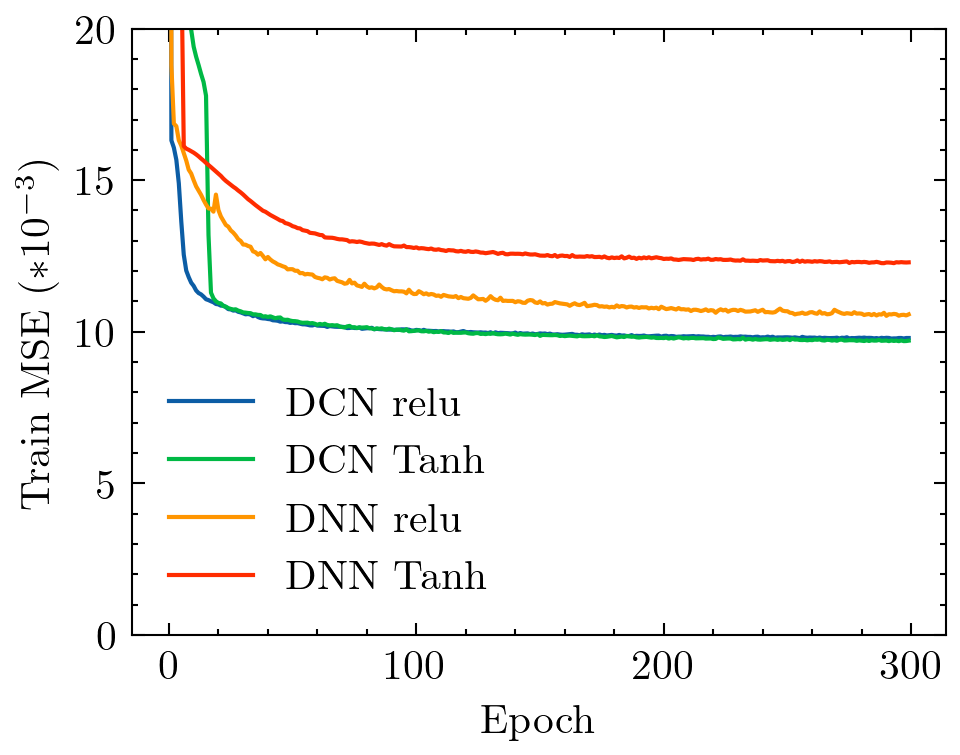

In [12]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(0, 20)
    plt.plot(tll_cnn_relu_mult1000, label='DCN relu')
    plt.plot(tll_cnn_tanh_mult1000, label='DCN Tanh')
    plt.plot(tll_dnn_relu_mult1000, label='DNN relu')
    plt.plot(tll_dnn_tanh_mult1000, label='DNN Tanh')
    plt.xlabel('Epoch')
    plt.ylabel('Train MSE ($ *10^{-3}$)')
    plt.legend()
    #save figure
    plt.savefig(figure_savepath + 'Train Loss_compare.pdf')
    plt.show()

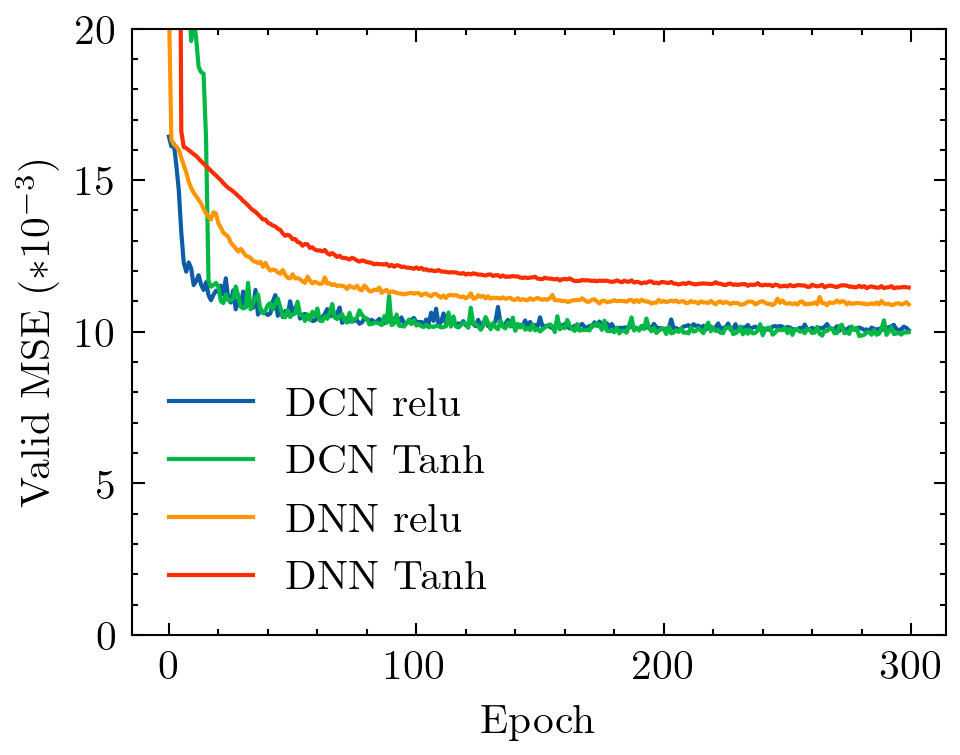

In [13]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(0, 20)
    plt.plot(vll_cnn_relu_mult1000, label='DCN relu')
    plt.plot(vll_cnn_tanh_mult1000, label='DCN Tanh')
    plt.plot(vll_dnn_relu_mult1000, label='DNN relu')
    plt.plot(vll_dnn_tanh_mult1000, label='DNN Tanh')
    plt.xlabel('Epoch')
    plt.ylabel('Valid MSE ($ *10^{-3}$)')
    plt.legend()
    #save figure
    plt.savefig(figure_savepath + 'Valid Loss_compare.pdf')
    plt.show()